<div align="center">
<h1><img width="30" src="https://madewithml.com/static/images/rounded_logo.png">&nbsp;<a href="https://madewithml.com/">Made With ML</a></h1>
Applied ML · MLOps · Production
<br>
Join 20K+ developers in learning how to responsibly <a href="https://madewithml.com/about/">deliver value</a> with ML.
    <br>
</div>

<br>

<div align="center">
    <a target="_blank" href="https://newsletter.madewithml.com"><img src="https://img.shields.io/badge/Subscribe-20K-brightgreen"></a>&nbsp;
    <a target="_blank" href="https://github.com/GokuMohandas/MadeWithML"><img src="https://img.shields.io/github/stars/GokuMohandas/MadeWithML.svg?style=social&label=Star"></a>&nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/goku"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
    <a target="_blank" href="https://twitter.com/GokuMohandas"><img src="https://img.shields.io/twitter/follow/GokuMohandas.svg?label=Follow&style=social"></a>
    <br>
    🔥&nbsp; Among the <a href="https://github.com/topics/mlops" target="_blank">top MLOps</a> repositories on GitHub
</div>

<br>
<hr>

# MLOps - Tagifai

<div align="left">
<a target="_blank" href="https://madewithml.com/#mlops"><img src="https://img.shields.io/badge/📖 Read-lessons-9cf"></a>&nbsp;
<a href="https://github.com/GokuMohandas/MLOps/blob/main/notebooks/tagifai.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/GokuMohandas/MLOps/blob/main/notebooks/tagifai.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

This notebooks contains the code for our `Tagifai` feature including 🔢&nbsp; Data and 📈&nbsp; Modeling. After this, we'll be moving all of this code to Python scripts with proper styling, testing, etc.

> Be sure to checkout the accompanying [lessons](https://madewithml.com/courses/mlops) as opposed to just running the code here. The lessons will help us develop an intuition before jumping into the application.

# 🔢&nbsp; Data

## Labeling

In [1]:
from collections import Counter, OrderedDict
import ipywidgets as widgets
import itertools
import json
import pandas as pd
from urllib.request import urlopen

In [2]:
# Load projects
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/projects.json"
projects = json.loads(urlopen(url).read())
print (json.dumps(projects[-305], indent=2))

{
  "id": 2106,
  "created_on": "2020-08-08 15:06:18",
  "title": "Fast NST for Videos (+ person segmentation) \ud83c\udfa5 + \u26a1\ud83d\udcbb + \ud83c\udfa8 = \u2764\ufe0f",
  "description": "Create NST videos and pick separate styles for the person in the video and for the background.",
  "tags": [
    "code",
    "tutorial",
    "video",
    "computer-vision",
    "style-transfer",
    "neural-style-transfer"
  ]
}


In [3]:
# Load tags
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/tags.json"
tags = json.loads(urlopen(url).read())
tags_dict = {}
for item in tags:
    key = item.pop("tag")
    tags_dict[key] = item
print (f"{len(tags_dict)} tags")

400 tags


In [4]:
@widgets.interact(tag=list(tags_dict.keys()))
def display_tag_details(tag='question-answering'):
    print (json.dumps(tags_dict[tag], indent=2))

interactive(children=(Dropdown(description='tag', index=283, options=('3d', 'action-localization', 'action-rec…

In [5]:
# Create dataframe
df = pd.DataFrame(projects)
print (f"{len(df)} projects")
df.head(5)

2032 projects


,id,created_on,title,description,tags
0,1,2020-02-17 06:30:41,Machine Learning Basics,A practical set of notebooks on machine learni...,"[code, tutorial, keras, pytorch, tensorflow, d..."
1,2,2020-02-17 06:41:45,Deep Learning with Electronic Health Record (E...,A comprehensive look at recent machine learnin...,"[article, tutorial, deep-learning, health, ehr]"
2,3,2020-02-20 06:07:59,Automatic Parking Management using computer vi...,Detecting empty and parked spaces in car parki...,"[code, tutorial, video, python, machine-learni..."
3,4,2020-02-20 06:21:57,Easy street parking using region proposal netw...,Get a text on your phone whenever a nearby par...,"[code, tutorial, python, pytorch, machine-lear..."
4,5,2020-02-20 06:29:18,Deep Learning based parking management system ...,Fastai provides easy to use wrappers to quickl...,"[code, tutorial, fastai, deep-learning, parkin..."


## Preprocessing

Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we [split](https://madewithml.com/courses/mlops/splitting) the data first before preprocessing to avoid data leaks.

We can combine existing input features to create new meaningful signal (helping the model learn). 

In [6]:
# Feature engineering
df["text"] = df.title + " " + df.description

Filter tags above a certain frequency threshold because those with fewer samples won't be adequate for training.

In [7]:
def filter(l, include=[], exclude=[]):
    """Filter a list using inclusion and exclusion lists of items."""
    filtered = [item for item in l if item in include and item not in exclude]
    return filtered

In [8]:
# Inclusion/exclusion criteria for tags
include = list(tags_dict.keys())
exclude = ["machine-learning", "deep-learning",  "data-science",
           "neural-networks", "python", "r", "visualization", "wandb"]

In [9]:
# Filter tags for each project
df.tags = df.tags.apply(filter, include=include, exclude=exclude)
tags = Counter(itertools.chain.from_iterable(df.tags.values))

We're also going to restrict the mapping to only tags that are above a certain frequency threshold. The tags that don't have enough projects will not have enough samples to model their relationships.

In [10]:
@widgets.interact(min_tag_freq=(0, tags.most_common()[0][1]))
def separate_tags_by_freq(min_tag_freq=30):
    tags_above_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] >= min_tag_freq)
    tags_below_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] < min_tag_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(5))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-5:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(5))

interactive(children=(IntSlider(value=30, description='min_tag_freq', max=424), Output()), _dom_classes=('widg…

In [11]:
# Filter tags that have fewer than <min_tag_freq> occurrences
min_tag_freq = 30
tags_above_freq = Counter(tag for tag in tags.elements() 
                          if tags[tag] >= min_tag_freq)
df.tags = df.tags.apply(filter, include=list(tags_above_freq.keys()))

Remove inputs that have no remaining (not enough frequency) tags.

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [13]:
# Remove projects with no more remaining relevant tags
df = df[df.tags.map(len) > 0]
print (f"{len(df)} projects")

1439 projects


Since we're dealing with text data, we can apply some of the common preparation processes:

In [14]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to /Users/goku/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def preprocess(text, lower=True, stem=False, 
               filters="[!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~]", 
               stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    if lower: 
        text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub(filters, r"", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric chars
    text = re.sub(' +', ' ', text)  # remove multiple spaces
    text = text.strip()

    # Remove links
    text = re.sub(r'http\S+', '', text)

    # Stemming
    if stem:
        text = " ".join([porter.stem(word) for word in text.split(' ')])

    return text

In [16]:
@widgets.interact(lower=True, stem=False)
def display_preprocessed_text(lower, stem):
    text = "Conditional image generation using Variational Autoencoders and GANs."
    preprocessed_text = preprocess(text=text, lower=lower, stem=stem)
    print (preprocessed_text)    

interactive(children=(Checkbox(value=True, description='lower'), Checkbox(value=False, description='stem'), Ou…

In [17]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(preprocess, lower=True, stem=False)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Machine Learning Basics A practical set of notebooks on machine learning basics, implemented in both TF2.0 + Keras and PyTorch.
machine learning basics practical set notebooks machine learning basics implemented tf2 0 keras pytorch


## Exploratory Data Analysis (EDA)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
sns.set_theme()
warnings.filterwarnings("ignore")

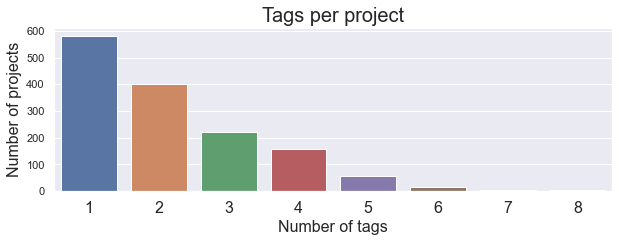

In [19]:
# Number of tags per project
num_tags_per_project = [len(tags) for tags in df.tags]
num_tags, num_projects = zip(*Counter(num_tags_per_project).items())
plt.figure(figsize=(10, 3))
ax = sns.barplot(list(num_tags), list(num_projects))
plt.title("Tags per project", fontsize=20)
plt.xlabel("Number of tags", fontsize=16)
ax.set_xticklabels(range(1, len(num_tags)+1), rotation=0, fontsize=16)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

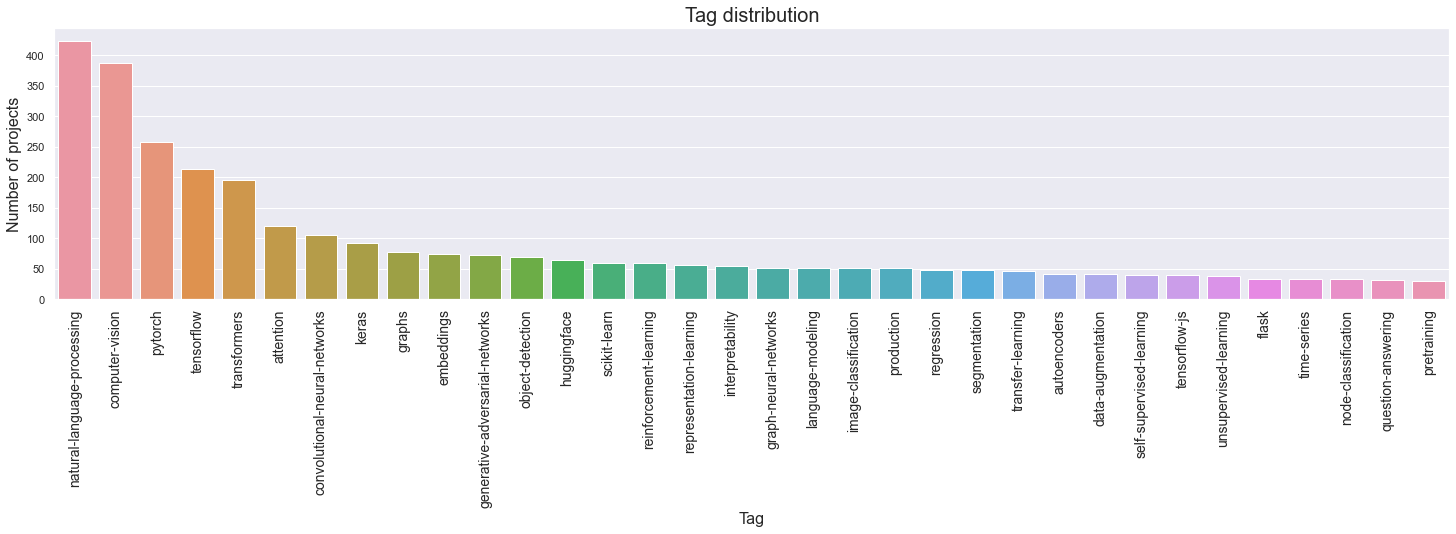

In [20]:
# Distribution of tags
all_tags = list(itertools.chain.from_iterable(df.tags.values))
tags, tag_counts = zip(*Counter(all_tags).most_common())
plt.figure(figsize=(25, 5))
ax = sns.barplot(list(tags), list(tag_counts))
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=14)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

In [21]:
@widgets.interact(tag=list(tags))
def display_word_cloud(tag="pytorch"):
    # Plot word clouds top top tags
    plt.figure(figsize=(15, 5))
    subset = df[df.tags.apply(lambda tags: tag in tags)]
    text = subset.text.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

interactive(children=(Dropdown(description='tag', index=2, options=('natural-language-processing', 'computer-v…

## Label encoding

In [ ]:
import numpy as np
import random

In [ ]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

In [ ]:
# Shuffle
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Get data
X = df.text.to_numpy()
y = df.tags

We'll be writing our own LabelEncoder which is based on scikit-learn's [implementation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). 

In [ ]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(list(itertools.chain.from_iterable(y)))
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        y_one_hot = np.zeros((len(y), len(self.class_to_index)), dtype=int)
        for i, item in enumerate(y):
            for class_ in item:
                y_one_hot[i][self.class_to_index[class_]] = 1
        return y_one_hot

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            indices = np.where(item == 1)[0]
            classes.append([self.index_to_class[index] for index in indices])
        return classes

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

In [ ]:
label_encoder.class_to_index

{'attention': 0,
 'autoencoders': 1,
 'computer-vision': 2,
 'convolutional-neural-networks': 3,
 'data-augmentation': 4,
 'embeddings': 5,
 'flask': 6,
 'generative-adversarial-networks': 7,
 'graph-neural-networks': 8,
 'graphs': 9,
 'huggingface': 10,
 'image-classification': 11,
 'interpretability': 12,
 'keras': 13,
 'language-modeling': 14,
 'natural-language-processing': 15,
 'node-classification': 16,
 'object-detection': 17,
 'pretraining': 18,
 'production': 19,
 'pytorch': 20,
 'question-answering': 21,
 'regression': 22,
 'reinforcement-learning': 23,
 'representation-learning': 24,
 'scikit-learn': 25,
 'segmentation': 26,
 'self-supervised-learning': 27,
 'tensorflow': 28,
 'tensorflow-js': 29,
 'time-series': 30,
 'transfer-learning': 31,
 'transformers': 32,
 'unsupervised-learning': 33}

In [ ]:
# Sample
label_encoder.encode([["attention", "data-augmentation"]])

array([[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

(1439, 34)


## Splitting

In [ ]:
!pip install scikit-multilearn==0.2.0 -q

You need to [clean](https://madewithml.com/courses/applied-ml/preprocessing/) your data first before splitting, at least for the features that splitting depends on. So the process is more like: preprocessing (global, cleaning) → splitting → preprocessing (local, transformations). We're splitting using the tag labels which have already been inspected and cleaned during EDA. 

**Naive split**

In [ ]:
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

In [ ]:
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

For simple multiclass classification, you can specify how to stratify the split by adding the [`stratify`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) keyword argument. But our task is multilabel classification, so we'll need to use other techniques to create even splits.

In [ ]:
# Split (train)
X_train, X_, y_train, y_ = train_test_split(X, y, train_size=train_size)

In [ ]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 1007 (0.70)
remaining: 432 (0.30)


In [ ]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5)

In [ ]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 1007 (0.70)
val: 216 (0.15)
test: 216 (0.15)


In [ ]:
# Get counts for each class
counts = {}
counts['train_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_train, order=1) for combination in row)
counts['val_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_val, order=1) for combination in row)
counts['test_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_test, order=1) for combination in row)

In [ ]:
# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,"(20,)","(15,)","(32,)","(14,)","(10,)","(21,)","(5,)","(2,)","(3,)","(17,)","(22,)","(25,)","(28,)","(0,)","(13,)","(11,)","(4,)","(27,)","(6,)","(16,)","(9,)","(23,)","(19,)","(26,)","(31,)","(7,)","(30,)","(18,)","(29,)","(1,)","(12,)","(24,)","(33,)","(8,)"
train,181,290,130,34,47,21,51,271,76,53,34,42,151,78,71,37,31,30,27,22,52,44,32,30,34,53,18,18,28,29,42,42,27,31
val,39,60,29,8,10,5,11,54,17,10,9,12,31,18,15,6,3,6,3,6,16,8,8,12,5,7,9,7,7,8,8,10,8,12
test,38,74,37,9,7,6,13,63,13,6,6,6,31,24,7,8,7,4,4,5,10,7,11,6,7,13,7,5,5,4,5,5,4,8


It's hard to compare these because our train and test proportions are different. Let's see what the distribution looks like once we balance it out. What do we need to multiply our test ratio by so that we have the same amount as our train ratio?

$$ \alpha * N_{test} = N_{train} $$

$$ \alpha = \frac{N_{train}}{N_{test}} $$

In [ ]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))

In [ ]:
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df

,"(20,)","(15,)","(32,)","(14,)","(10,)","(21,)","(5,)","(2,)","(3,)","(17,)","(22,)","(25,)","(28,)","(0,)","(13,)","(11,)","(4,)","(27,)","(6,)","(16,)","(9,)","(23,)","(19,)","(26,)","(31,)","(7,)","(30,)","(18,)","(29,)","(1,)","(12,)","(24,)","(33,)","(8,)"
train,181,290,130,34,47,21,51,271,76,53,34,42,151,78,71,37,31,30,27,22,52,44,32,30,34,53,18,18,28,29,42,42,27,31
val,182,280,135,37,46,23,51,252,79,46,42,56,144,84,70,28,14,28,14,28,74,37,37,56,23,32,42,32,32,37,37,46,37,56
test,177,345,172,42,32,28,60,294,60,28,28,28,144,112,32,37,32,18,18,23,46,32,51,28,32,60,32,23,23,18,23,23,18,37


We can see how much deviance there is in our naive data splits by computing the standard deviation of each split's class counts from the mean (ideal split).

$ \sigma = \sqrt{\frac{(x - \bar{x})^2}{N}} $

In [ ]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

8.827353524695164

Some of these distributions are not great. Let's try and balance this out a bit better.

**Stratified split**

Now we'll apply [iterative stratification](http://lpis.csd.auth.gr/publications/sechidis-ecmlpkdd-2011.pdf) via the [skmultilearn](http://scikit.ml/index.html) library, which essentially splits each input into subsets (where each label is considered individually) and then it distributes the samples starting with fewest "positive" samples and working up to the inputs that have the most labels.

In [ ]:
from skmultilearn.model_selection import IterativeStratification

In [ ]:
def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which 
    'maintains balanced representation with respect 
    to order-th label combinations.'
    """
    stratifier = IterativeStratification(
        n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

In [ ]:
# Get data
X = df.text.to_numpy()
y = df.tags

In [ ]:
# Binarize y
label_encoder = LabelEncoder()
label_encoder.fit(y)
y = label_encoder.encode(y)

In [ ]:
# Split
X_train, X_, y_train, y_ = iterative_train_test_split(
    X, y, train_size=train_size)
X_val, X_test, y_val, y_test = iterative_train_test_split(
    X_, y_, train_size=0.5)

In [ ]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 1001 (0.70)
val: 226 (0.16)
test: 212 (0.15)


In [ ]:
# Get counts for each class
counts = {}
counts["train_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_train, order=1) for combination in row)
counts["val_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_val, order=1) for combination in row)
counts["test_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_test, order=1) for combination in row)

In [ ]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))

In [ ]:
# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,"(6,)","(2,)","(30,)","(27,)","(20,)","(13,)","(3,)","(24,)","(15,)","(32,)","(22,)","(26,)","(28,)","(29,)","(7,)","(17,)","(1,)","(12,)","(25,)","(4,)","(8,)","(9,)","(31,)","(33,)","(19,)","(21,)","(14,)","(11,)","(5,)","(10,)","(16,)","(0,)","(23,)","(18,)"
train,24,272,24,28,181,65,74,39,297,141,34,31,149,27,51,42,29,38,42,29,36,55,32,27,36,22,40,41,52,49,22,84,41,19
val,23,270,23,28,177,70,74,42,298,130,32,42,149,28,51,51,18,37,42,28,32,51,32,28,37,28,28,14,56,42,23,84,42,4
test,23,270,23,28,182,60,74,42,294,126,37,37,149,32,51,74,37,42,42,28,37,56,32,28,32,18,23,32,51,28,28,84,42,46


In [ ]:
dist_df = pd.DataFrame({
    'train': counts['train_counts'],
    'val': counts['val_counts'],
    'test': counts['test_counts']
}).T.fillna(0)

In [ ]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

3.264013498715306

> [Iterative stratification](http://scikit.ml/_modules/skmultilearn/model_selection/iterative_stratification.html#IterativeStratification) essentially creates splits while "trying to maintain balanced representation with respect to order-th label combinations". We used to an `order=1` for our iterative split which means we cared about providing representative distribution of each tag across the splits. But we can account for [higher-order](https://arxiv.org/abs/1704.08756) label relationships as well where we may care about the distribution of label combinations.

In [ ]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tags": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tags": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tags": label_encoder.decode(y_test)})

In [ ]:
train_df.head()

,text,tags
0,google stock price prediction using alpha vant...,[flask]
1,pifuhd high resolution 3d human digitization r...,[computer-vision]
2,neural cdes long time series via log ode metho...,[time-series]
3,dpod pose estimator pytorch recreation sota 6d...,[computer-vision]
4,pytorch metric learning easiest way use deep m...,"[pytorch, self-supervised-learning]"


## Augmentation

We'll often want to increase the size and diversity of our training data split through data augmentation. It involves using the existing samples to generate synthetic, yet realistic, examples.

In [ ]:
!pip install nlpaug==1.1.0 transformers==3.0.2 -q
!pip install snorkel==0.9.7 -q

In [ ]:
import nlpaug.augmenter.word as naw

In [ ]:
# Load tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="insert")

In [ ]:
text = "Conditional image generation using Variational Autoencoders and GANs."

In [ ]:
# Substitutions
augmented_text = substitution.augment(text)
print (augmented_text)

indirect flow processing using variational filter and gans.


Substitution doesn't seem like a great idea for us because there are certain keywords that provide strong signal for our tags so we don't want to alter those. Also, note that these augmentations are NOT deterministic and will vary every time we run them. Let's try insertion...

In [ ]:
# Insertions
augmented_text = insertion.augment(text)
print (augmented_text)

optimization conditional on image generation technique using linear variational autoencoders and gans.


A little better but still quite fragile and now it can potentially insert key words that can influence false positive tags to appear. Maybe instead of substituting or inserting new tokens, let's try simply swapping machine learning related keywords with their aliases from our [auxiliary data](https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/tags.json). We'll use Snorkel's [transformation functions](https://www.snorkel.org/use-cases/02-spam-data-augmentation-tutorial) to easily achieve this.

In [ ]:
import inflect
from snorkel.augmentation import transformation_function
inflect = inflect.engine()

In [ ]:
# Inflect
print (inflect.singular_noun("graphs"))
print (inflect.singular_noun("graph"))
print (inflect.plural_noun("graph"))
print (inflect.plural_noun("graphs"))

graph
False
graphs
graphss


In [ ]:
def replace_dash(x):
    return x.replace("-", " ")

In [ ]:
flat_tags_dict = {}
for tag, info in tags_dict.items():
    tag = tag.replace("-", " ")
    aliases = list(map(replace_dash, info["aliases"]))
    if len(aliases):
        flat_tags_dict[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flat_tags_dict[alias] = _aliases

In [ ]:
# Tags that could be singular or plural
can_be_singular = [
    'animations',
    'cartoons',
    'autoencoders',
    'conditional random fields',
    'convolutional neural networks',
    'databases',
    'deep q networks',
    'gated recurrent units',
    'gaussian processes',
    'generative adversarial networks',
    'graph convolutional networks',
    'graph neural networks',
    'k nearest neighbors',
    'learning rates',
    'multilayer perceptrons',
    'outliers',
    'pos',
    'quasi recurrent neural networks',
    'recommendation systems',
    'recurrent neural networks',
    'streaming data',
    'data streams',
    'support vector machines',
    'variational autoencoders']
can_be_plural = [
    'annotation',
    'data annotation',
    'continuous integration',
    'continuous deployment',
    'crf',
    'conversational ai',
    'chatbot',
    'cnn',
    'db',
    'dqn',
    'expectation maximization',
    'fine tuning',
    'finetuning',
    'finetune',
    'gru',
    'gan',
    'gcn',
    'gnn',
    'hyperparameter optimization',
    'hyperparameter tuning',
    'image generation',
    'inference',
    'prediction',
    'knn',
    'knowledge base',
    'language modeling',
    'latent dirichlet allocation',
    'lstm',
    'machine translation',
    'model compression',
    'compression',
    'perceptron',
    'mlp',
    'optical character recognition',
    'outlier detection',
    'pos tagging',
    'pca',
    'qrnn',
    'rnn',
    'segmentation',
    'image segmentation',
    'spatial temporal cnn',
    'data streaming',
    'svm',
    'tabular',
    'temporal cnn',
    'tcnn',
    'vae',
    'vqa',
    'visualization',
    'data visualization']

In [ ]:
# Add to flattened dict
for tag in can_be_singular:
    flat_tags_dict[inflect.singular_noun(tag)] = flat_tags_dict[tag]
for tag in can_be_plural:
    flat_tags_dict[inflect.plural_noun(tag)] = flat_tags_dict[tag]

In [ ]:
# Doesn't perfectly match (ex. singlar tag to singlar alias)
# But good enough for data augmentation for char-level tokenization
# Could've also used stemming before swapping aliases
print (flat_tags_dict["gan"])
print (flat_tags_dict["gans"])
print (flat_tags_dict["generative adversarial network"])
print (flat_tags_dict["generative adversarial networks"])

['generative adversarial networks']
['generative adversarial networks']
['gan']
['gan']


In [ ]:
# We want to match with the whole word only
print ("gan" in "This is a gan.")
print ("gan" in "This is gandalf.")

True
True


In [ ]:
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)

In [ ]:
# Correct behavior (single instance)
print (find_word("gan", "This is a gan."))
print (find_word("gan", "This is gandalf."))

<re.Match object; span=(10, 13), match='gan'>
None


In [ ]:
@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases.""" 

    # Find all matches
    matches = []
    for i, tag in enumerate(flat_tags_dict):
        match = find_word(tag, x.text)  
        if match:
            matches.append(match)
    
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(flat_tags_dict[tag])}{x.text[match.end():]}"
    return x

In [ ]:
# Swap
for i in range(3):
    sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
    sample_df.text = sample_df.text.apply(preprocess, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

survey reinforcement learning nlproc tasks
survey rl nlp tasks
survey rl nlp tasks


In [ ]:
# Undesired behavior (needs contextual insight)
for i in range(3):
    sample_df = pd.DataFrame([{"text": "Autogenerate your CV to apply for jobs using NLP."}])
    sample_df.text = sample_df.text.apply(preprocess, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

autogenerate vision apply jobs using nlp
autogenerate cv apply jobs using natural language processing
autogenerate cv apply jobs using nlproc


Now we'll define a [augmentation policy](https://snorkel.readthedocs.io/en/v0.9.1/packages/augmentation.html) to apply our transformation functions with certain rules (how many samples to generate, whether to keep the original data point, etc.)

In [ ]:
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier

In [ ]:
# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=["text"], inplace=True)
train_df_augmented.head()

100%|██████████| 1001/1001 [00:15<00:00, 66.10it/s]


,text,tags
0,google stock price prediction using alpha vant...,[flask]
0,google stock price inference using alpha vanta...,[flask]
1,pifuhd high resolution 3d human digitization r...,[computer-vision]
1,pifuhd high resolution three dimensional human...,[computer-vision]
1,pifuhd high resolution 3 dimensional human dig...,[computer-vision]


In [ ]:
len(train_df), len(train_df_augmented)

(1001, 1981)

For now, we'll skip the data augmentation because it's quite fickle and empirically it doesn't improvement performance much. But we can see how this can be very effective once we can control what type of vocabulary to augment on and what exactly to augment with.

> Regardless of what method we use, it's important to validate that we're not just augmenting for the sake of augmentation. We can do this by executing any existing [data validation tests](https://madewithml.com/courses/mlops/testing#data) and even creating specific tests to apply on augmented data.

# 📈&nbsp; Modeling

We'll begin modeling by starting with the simplest baseline and slowly adding complexity.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import torch

In [ ]:
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

In [ ]:
def get_data_splits(df, train_size=0.7):
    """"""
    # Get data
    X = df.text.to_numpy()
    y = df.tags

    # Binarize y
    label_encoder = LabelEncoder()
    label_encoder.fit(y)
    y = label_encoder.encode(y)

    # Split
    X_train, X_, y_train, y_ = iterative_train_test_split(
        X, y, train_size=train_size)
    X_val, X_test, y_val, y_test = iterative_train_test_split(
        X_, y_, train_size=0.5)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder

In [ ]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = torch.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                y_prob = self.model(inputs)

                # Store outputs
                y_probs.extend(y_prob)

        return np.vstack(y_probs)
    
    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model

## Random

<u><i>motivation</i></u>: We want to know what random (chance) performance looks like. All of our efforts should be well above this.

In [ ]:
# Set seeds
set_seeds()

In [ ]:
# Get data splits
preprocessed_df = df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)

In [ ]:
# Label encoder
print (label_encoder)
print (label_encoder.classes)

<LabelEncoder(num_classes=34)>
['attention', 'autoencoders', 'computer-vision', 'convolutional-neural-networks', 'data-augmentation', 'embeddings', 'flask', 'generative-adversarial-networks', 'graph-neural-networks', 'graphs', 'huggingface', 'image-classification', 'interpretability', 'keras', 'language-modeling', 'natural-language-processing', 'node-classification', 'object-detection', 'pretraining', 'production', 'pytorch', 'question-answering', 'regression', 'reinforcement-learning', 'representation-learning', 'scikit-learn', 'segmentation', 'self-supervised-learning', 'tensorflow', 'tensorflow-js', 'time-series', 'transfer-learning', 'transformers', 'unsupervised-learning']


In [ ]:
# Generate random predictions
y_pred = np.random.randint(low=0, high=2, size=(len(y_test), len(label_encoder.classes)))
print (y_pred.shape)
print (y_pred[0:5])

(220, 34)
[[0 1 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1]
 [1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0]
 [0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1]
 [0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0]
 [0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1]]


In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.12590604458654545,
  "recall": 0.5203426124197003,
  "f1": 0.18469743862395557
}


We made the assumption that there is an equal probability for whether an input has a tag or not but this isn't true. Let's use the **train split** to figure out what the true probability is.

In [ ]:
# Percentage of 1s (tag presence)
tag_p = np.sum(np.sum(y_train)) / (len(y_train) * len(label_encoder.classes))
print (tag_p)

0.06384791678909325


In [ ]:
# Generate weighted random predictions
y_pred = np.random.choice(
    np.arange(0, 2), size=(len(y_test), len(label_encoder.classes)), 
    p=[1-tag_p, tag_p])

In [ ]:
# Validate percentage
np.sum(np.sum(y_pred)) / (len(y_pred) * len(label_encoder.classes))

0.06390374331550802

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.1121905967477629,
  "recall": 0.047109207708779445,
  "f1": 0.05309836327850377
}


<u><i>limitations</i></u>: we didn't use the tokens in our input to affect our predictions so nothing was learned.

## Rule-based

<u><i>motivation</i></u>: we want to use signals in our inputs (along with domain expertise and auxiliary data) to determine the labels.

In [ ]:
# Set seeds
set_seeds()

### Unstemmed

In [ ]:
# Get data splits
preprocessed_df = df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)

In [ ]:
# Restrict to relevant tags
print (len(tags_dict))
tags_dict = {tag: tags_dict[tag] for tag in label_encoder.classes}
print (len(tags_dict))

400
34


In [ ]:
# Map aliases
aliases = {}
for tag, values in tags_dict.items():
    aliases[preprocess(tag)] = tag
    for alias in values["aliases"]:
        aliases[preprocess(alias)] = tag
aliases

{'ae': 'autoencoders',
 'attention': 'attention',
 'autoencoders': 'autoencoders',
 'cnn': 'convolutional-neural-networks',
 'computer vision': 'computer-vision',
 'convolutional neural networks': 'convolutional-neural-networks',
 'cv': 'computer-vision',
 'data augmentation': 'data-augmentation',
 'embeddings': 'embeddings',
 'flask': 'flask',
 'gan': 'generative-adversarial-networks',
 'generative adversarial networks': 'generative-adversarial-networks',
 'gnn': 'graph-neural-networks',
 'graph neural networks': 'graph-neural-networks',
 'graphs': 'graphs',
 'huggingface': 'huggingface',
 'image classification': 'image-classification',
 'image segmentation': 'segmentation',
 'interpretability': 'interpretability',
 'keras': 'keras',
 'language modeling': 'language-modeling',
 'lm': 'language-modeling',
 'natural language processing': 'natural-language-processing',
 'nlp': 'natural-language-processing',
 'nlproc': 'natural-language-processing',
 'node classification': 'node-classifica

In [ ]:
def get_classes(text, aliases, tags_dict):
    """If a token matches an alias, 
    then add the corresponding tag
    class (and parent tags if any)."""
    classes = []
    for alias, tag in aliases.items():
        if alias in text:
            classes.append(tag)
            for parent in tags_dict[tag]["parents"]:
                classes.append(parent)
    return list(set(classes))

In [ ]:
# Sample
text = "This project extends gans for data augmentation specifically for object detection tasks."
get_classes(text=preprocess(text), aliases=aliases, tags_dict=tags_dict)

['generative-adversarial-networks',
 'data-augmentation',
 'object-detection',
 'computer-vision']

In [ ]:
# Prediction
y_pred = []
for text in X_test:
    classes = get_classes(text, aliases, tags_dict)
    y_pred.append(classes)

In [ ]:
# Encode labels
y_pred = label_encoder.encode(y_pred)

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.886542414851697,
  "recall": 0.430406852248394,
  "f1": 0.556927275918014
}


### Stemmed

We're looking for exact matches with the aliases which isn't always perfect, for example:

In [ ]:
print (aliases[preprocess("gan")])
# print (aliases[preprocess("gans")]) # this won't find any match
print (aliases[preprocess("generative adversarial networks")])
# print (aliases[preprocess("generative adversarial network")]) # this won't find any match

generative-adversarial-networks
generative-adversarial-networks


We don't want to keep adding explicit rules but we can use [stemming](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) to represent different forms of a word uniformly, for example:

In [ ]:
print (porter.stem("democracy"))
print (porter.stem("democracies"))

democraci
democraci


So let's now stem our aliases as well as the tokens in our input text and then look for matches:

In [ ]:
# Get data splits
preprocessed_df = df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True, stem=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)

In [ ]:
# Map aliases
aliases = {}
for tag, values in tags_dict.items():
    aliases[preprocess(tag, stem=True)] = tag
    for alias in values["aliases"]:
        aliases[preprocess(alias, stem=True)] = tag
aliases

{'ae': 'autoencoders',
 'attent': 'attention',
 'autoencod': 'autoencoders',
 'cnn': 'convolutional-neural-networks',
 'comput vision': 'computer-vision',
 'convolut neural network': 'convolutional-neural-networks',
 'cv': 'computer-vision',
 'data augment': 'data-augmentation',
 'embed': 'embeddings',
 'flask': 'flask',
 'gan': 'generative-adversarial-networks',
 'gener adversari network': 'generative-adversarial-networks',
 'gnn': 'graph-neural-networks',
 'graph': 'graphs',
 'graph neural network': 'graph-neural-networks',
 'huggingfac': 'huggingface',
 'imag classif': 'image-classification',
 'imag segment': 'segmentation',
 'interpret': 'interpretability',
 'kera': 'keras',
 'languag model': 'language-modeling',
 'lm': 'language-modeling',
 'natur languag process': 'natural-language-processing',
 'nlp': 'natural-language-processing',
 'nlproc': 'natural-language-processing',
 'node classif': 'node-classification',
 'object detect': 'object-detection',
 'pre train': 'pretraining',


In [ ]:
# Checks (we will write proper tests soon)
print (aliases[preprocess("gan", stem=True)])
print (aliases[preprocess("gans", stem=True)])
print (aliases[preprocess("generative adversarial network", stem=True)])
print (aliases[preprocess("generative adversarial networks", stem=True)])

generative-adversarial-networks
generative-adversarial-networks
generative-adversarial-networks
generative-adversarial-networks


In [ ]:
# Sample
text = "This project extends gans for data augmentation specifically for object detection tasks."
get_classes(text=preprocess(text, stem=True), aliases=aliases, tags_dict=tags_dict)

['generative-adversarial-networks',
 'data-augmentation',
 'object-detection',
 'computer-vision']

In [ ]:
# Prediction
y_pred = []
for text in X_test:
    classes = get_classes(text, aliases, tags_dict)
    y_pred.append(classes)

In [ ]:
# Encode labels
y_pred = label_encoder.encode(y_pred)

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.907266867724384,
  "recall": 0.485838779956427,
  "f1": 0.6120705676738784
}


A nice improvement from the unstemmed approach! This is because rule-based approaches can yield labels with high certainty when there is an absolute condition match but it fails to generalize or learn implicit patterns.

### Inference

In [ ]:
# Infer
text = "Transfer learning with transformers for self-supervised learning"
print (preprocess(text, stem=True))
get_classes(text=preprocess(text, stem=True), aliases=aliases, tags_dict=tags_dict)

transfer learn transform self supervis learn


['self-supervised-learning', 'transfer-learning', 'transformers']

Now let's see what happens when we replace the word *transformers* with *BERT*. Sure we can add this as an alias but we can't keep doing this. This is where it makes sense to learn from the data as opposed to creating explicit rules.

In [ ]:
# Infer
text = "Transfer learning with BERT for self-supervised learning"
print (preprocess(text, stem=True))
get_classes(text=preprocess(text, stem=True), aliases=aliases, tags_dict=tags_dict)

transfer learn bert self supervis learn


['self-supervised-learning', 'transfer-learning']

<u><i>limitations</i></u>: we failed to generalize or learn any implicit patterns to predict the labels because we treat the tokens in our input as isolated entities.

> We would ideally spend more time tuning our model because it's so simple and quick to train. This approach also applies to all the other models we'll look at as well.

## Simple ML

<u><i>motivation</i></u>:
- *representation*: use term frequency-inverse document frequency [(TF-IDF)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) to capture the significance of a token to a particular input with respect to all the inputs, as opposed to treating the words in our input text as isolated tokens.
- *architecture*: we want our model to meaningfully extract the encoded signal to predict the output labels.

So far we've treated the words in our input text as isolated tokens and we haven't really captured any meaning between tokens. Let's use term frequency–inverse document frequency (**TF-IDF**) to capture the significance of a token to a particular input with respect to all the inputs.

$$ w_{i, j} = \text{tf}_{i, j} * log(\frac{N}{\text{df}_i}) $$

$$ w_{i, j}: \text{tf-idf weight for term i in document j} $$
$$ \text{tf}_{i, j}: \text{# of times term i appear in document j} $$
$$ N: \text{total # of documents} $$
$$ {\text{df}_i}: \text{# of documents with token i} $$

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

In [ ]:
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
# Set seeds
set_seeds()

In [ ]:
# Get data splits
preprocessed_df = df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True, stem=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)

In [ ]:
# Tf-idf
vectorizer = TfidfVectorizer()
print (X_train[0])
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)
print (X_train.shape)
print (X_train[0]) # scipy.sparse.csr_matrix

googl stock price predict use alpha vantag api predict googl stock price
(1001, 2644)
  (0, 171)	0.18402828204128507
  (0, 2524)	0.28550249860372
  (0, 133)	0.28550249860372
  (0, 2512)	0.09560887050318034
  (0, 1810)	0.33011093957155024
  (0, 1826)	0.48407866396490795
  (0, 2242)	0.5161605871958589
  (0, 1036)	0.4292342539533268


In [ ]:
def fit_and_evaluate(model):
    """Fit and evaluate each model."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    return {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

In [ ]:
# Models
performance = {}
performance["logistic-regression"] = fit_and_evaluate(OneVsRestClassifier(
    LogisticRegression(), n_jobs=1))
performance["k-nearest-neighbors"] = fit_and_evaluate(
    KNeighborsClassifier())
performance["random-forest"] = fit_and_evaluate(
    RandomForestClassifier(n_jobs=-1))
performance["gradient-boosting-machine"] = fit_and_evaluate(OneVsRestClassifier(
    GradientBoostingClassifier()))
performance["support-vector-machine"] = fit_and_evaluate(OneVsRestClassifier(
    LinearSVC(), n_jobs=-1))
print (json.dumps(performance, indent=2))

{
  "logistic-regression": {
    "precision": 0.633369022127052,
    "recall": 0.21841541755888652,
    "f1": 0.3064204603390899
  },
  "k-nearest-neighbors": {
    "precision": 0.7410281119097024,
    "recall": 0.47109207708779444,
    "f1": 0.5559182508714337
  },
  "random-forest": {
    "precision": 0.7671229819121077,
    "recall": 0.3468950749464668,
    "f1": 0.456815177241668
  },
  "gradient-boosting-machine": {
    "precision": 0.8406418053383276,
    "recall": 0.6145610278372591,
    "f1": 0.7011673819277087
  },
  "support-vector-machine": {
    "precision": 0.8938397993500261,
    "recall": 0.5460385438972163,
    "f1": 0.6527334570244009
  }
}


<u><i>limitations</i></u>:
- *representation*: TF-IDF representations don't encapsulate much signal beyond frequency but we require more fine-grained token representations.
- *architecture*: we want to develop models that can use better represented encodings in a more contextual manner.

## CNN w/ Embeddings

<u><i>motivation</i></u>:
- *representation*: we want to have more robust (split tokens to characters) and meaningful ([embeddings](https://madewithml.com/courses/ml-foundations/embeddings/) representations for our input tokens.
- *architecture*: we want to process our encoded inputs using [convolution (CNN)](https://madewithml.com/courses/ml-foundations/convolutional-neural-networks/) filters that can learn to analyze windows of embedded tokens to extract meaningful signal (n-gram feature extractors).

### Set up

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Set seeds
set_seeds()

In [ ]:
# Get data splits
preprocessed_df = df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)

In [ ]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tags": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tags": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tags": label_encoder.decode(y_test)})

In [ ]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cuda


### Tokenizer

We're going to tokenize our input text as character tokens so we can be robust to spelling errors and learn to generalize across tags. (ex. learning that RoBERTa, or any other future BERT based archiecture, warrants same tag as BERT).

<img width="500px" src="https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/images/basics/cnn/inputs.png">

In [ ]:
class Tokenizer(object):
    def __init__(self, char_level, num_tokens=None, 
                 pad_token="<PAD>", oov_token="<UNK>",
                 token_to_index=None):
        self.char_level = char_level
        self.separator = '' if self.char_level else ' '
        if num_tokens: num_tokens -= 2 # pad + unk tokens
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)

    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"

    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(" ") for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(' ')
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]))
            sequences.append(np.asarray(sequence))
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append(self.separator.join([token for token in text]))
        return texts

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {
                "char_level": self.char_level,
                "oov_token": self.oov_token,
                "token_to_index": self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
# Tokenize
char_level = True
tokenizer = Tokenizer(char_level=char_level)
tokenizer.fit_on_texts(texts=X_train)
vocab_size = len(tokenizer)
print (tokenizer)

<Tokenizer(num_tokens=39)>


In [ ]:
tokenizer.token_to_index

{' ': 2,
 '0': 29,
 '1': 31,
 '2': 26,
 '3': 32,
 '4': 35,
 '5': 33,
 '6': 37,
 '7': 38,
 '8': 36,
 '9': 34,
 '<PAD>': 0,
 '<UNK>': 1,
 'a': 6,
 'b': 20,
 'c': 12,
 'd': 14,
 'e': 3,
 'f': 19,
 'g': 15,
 'h': 18,
 'i': 4,
 'j': 28,
 'k': 23,
 'l': 11,
 'm': 16,
 'n': 5,
 'o': 10,
 'p': 13,
 'q': 30,
 'r': 8,
 's': 9,
 't': 7,
 'u': 17,
 'v': 21,
 'w': 24,
 'x': 25,
 'y': 22,
 'z': 27}

In [ ]:
# Convert texts to sequences of indices
X_train = np.array(tokenizer.texts_to_sequences(X_train))
X_val = np.array(tokenizer.texts_to_sequences(X_val))
X_test = np.array(tokenizer.texts_to_sequences(X_test))
preprocessed_text = tokenizer.sequences_to_texts([X_train[0]])[0]
print ("Text to indices:\n"
    f"  (preprocessed) → {preprocessed_text}\n"
    f"  (tokenized) → {X_train[0]}")

Text to indices:
  (preprocessed) → google stock price prediction using alpha vantage api predict google stock price
  (tokenized) → [15 10 10 15 11  3  2  9  7 10 12 23  2 13  8  4 12  3  2 13  8  3 14  4
 12  7  4 10  5  2 17  9  4  5 15  2  6 11 13 18  6  2 21  6  5  7  6 15
  3  2  6 13  4  2 13  8  3 14  4 12  7  2 15 10 10 15 11  3  2  9  7 10
 12 23  2 13  8  4 12  3]


### Data imbalance

We'll factor class weights in our objective function ([binary cross entropy with logits](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)) to help with class imbalance. There are many other techniques such as over sampling from underrepresented classes, undersampling, etc. but we'll cover these in a separate unit lesson on data imbalance.

In [ ]:
# Class weights
counts = np.bincount([label_encoder.class_to_index[class_] for class_ in all_tags])
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [120  41 388 106  41  75  34  73  51  78  64  51  55  93  51 424  33  69
  30  51 258  32  49  59  57  60  48  40 213  40  34  46 196  39],
class weights: {0: 0.008333333333333333, 1: 0.024390243902439025, 2: 0.002577319587628866, 3: 0.009433962264150943, 4: 0.024390243902439025, 5: 0.013333333333333334, 6: 0.029411764705882353, 7: 0.0136986301369863, 8: 0.0196078431372549, 9: 0.01282051282051282, 10: 0.015625, 11: 0.0196078431372549, 12: 0.01818181818181818, 13: 0.010752688172043012, 14: 0.0196078431372549, 15: 0.0023584905660377358, 16: 0.030303030303030304, 17: 0.014492753623188406, 18: 0.03333333333333333, 19: 0.0196078431372549, 20: 0.003875968992248062, 21: 0.03125, 22: 0.02040816326530612, 23: 0.01694915254237288, 24: 0.017543859649122806, 25: 0.016666666666666666, 26: 0.020833333333333332, 27: 0.025, 28: 0.004694835680751174, 29: 0.025, 30: 0.029411764705882353, 31: 0.021739130434782608, 32: 0.00510204081632653, 33: 0.02564102564102564}


### Datasets

We're going to place our data into a [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and use a [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to efficiently create batches for training and evaluation.

In [ ]:
def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max length in sequence."""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    padded_sequences = np.zeros((len(sequences), max_seq_len))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

In [ ]:
class CNNTextDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_filter_size):
        self.X = X
        self.y = y
        self.max_filter_size = max_filter_size

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        batch = np.array(batch, dtype=object)
        X = batch[:, 0]
        y = np.stack(batch[:, 1], axis=0)

        # Pad inputs
        X = pad_sequences(sequences=X, max_seq_len=self.max_filter_size)

        # Cast
        X = torch.LongTensor(X.astype(np.int32))
        y = torch.FloatTensor(y.astype(np.int32))

        return X, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self,
            batch_size=batch_size,
            collate_fn=self.collate_fn,
            shuffle=shuffle,
            drop_last=drop_last,
            pin_memory=True)

In [ ]:
# Create datasets
filter_sizes = list(range(1, 11))
train_dataset = CNNTextDataset(
    X=X_train, y=y_train, max_filter_size=max(filter_sizes))
val_dataset = CNNTextDataset(
    X=X_val, y=y_val, max_filter_size=max(filter_sizes))
test_dataset = CNNTextDataset(
    X=X_test, y=y_test, max_filter_size=max(filter_sizes))
print ("Data splits:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {train_dataset[0][0]}\n"
    f"  y: {train_dataset[0][1]}")

Data splits:
  Train dataset:<Dataset(N=1001)>
  Val dataset: <Dataset(N=218)>
  Test dataset: <Dataset(N=220)>
Sample point:
  X: [15 10 10 15 11  3  2  9  7 10 12 23  2 13  8  4 12  3  2 13  8  3 14  4
 12  7  4 10  5  2 17  9  4  5 15  2  6 11 13 18  6  2 21  6  5  7  6 15
  3  2  6 13  4  2 13  8  3 14  4 12  7  2 15 10 10 15 11  3  2  9  7 10
 12 23  2 13  8  4 12  3]
  y: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Create dataloaders
batch_size = 128
train_dataloader = train_dataset.create_dataloader(
    batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(
    batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(
    batch_size=batch_size)
batch_X, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}")

Sample batch:
  X: [128, 197]
  y: [128, 34]


### Model

We'll be using a convolutional neural network on top of our embedded tokens to extract meaningful spatial signal. This time, we'll be using many filter widths to act as n-gram feature extractors. If you're not familiar with CNNs be sure to check out the [CNN lesson](https://madewithml.com/courses/ml-foundations/convolutional-neural-networks/) where we walkthrough every component of the architecture.

*italicized text*<img width="500px" src="https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/images/basics/cnn/convolution.gif">

Let's visualize the model's forward pass.

1. We'll first tokenize our inputs (`batch_size`, `max_seq_len`).
2. Then we'll embed our tokenized inputs (`batch_size`, `max_seq_len`, `embedding_dim`).
3. We'll apply convolution via filters (`filter_size`, `vocab_size`, `num_filters`) followed by batch normalization. Our filters act as character level n-gram detecors. We have three different filter sizes (2, 3 and 4) and they will act as bi-gram, tri-gram and 4-gram feature extractors, respectivelyy. 
4. We'll apply 1D global max pooling which will extract the most relevant information from the feature maps for making the decision.
5. We feed the pool outputs to a fully-connected (FC) layer (with dropout).
6. We use one more FC layer with softmax to derive class probabilities. 

<img width="5000px" src="https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/images/basics/cnn/model.png">

In [ ]:
# Arguments
embedding_dim = 128
num_filters = 128
hidden_dim = 128
dropout_p = 0.5

In [ ]:
class CNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_filters, filter_sizes,
                 hidden_dim, dropout_p, num_classes, padding_idx=0):
        super(CNN, self).__init__()

        # Initialize embeddings
        self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx)

        # Conv weights
        self.filter_sizes = filter_sizes
        self.conv = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim,
                       out_channels=num_filters,
                       kernel_size=f) for f in filter_sizes])

        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_filters*len(filter_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs, channel_first=False):

        # Embed
        x_in, = inputs
        x_in = self.embeddings(x_in)
        if not channel_first:
            x_in = x_in.transpose(1, 2)  # (N, channels, sequence length)

        z = []
        max_seq_len = x_in.shape[2]
        for i, f in enumerate(self.filter_sizes):

            # `SAME` padding
            padding_left = int(
                (self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2)
            padding_right = int(math.ceil(
                (self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2))

            # Conv
            _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))

            # Pool
            _z = F.max_pool1d(_z, _z.size(2)).squeeze(2)
            z.append(_z)

        # Concat outputs
        z = torch.cat(z, 1)

        # FC
        z = self.fc1(z)
        z = self.dropout(z)
        z = self.fc2(z)

        return z

Padding types:
* **VALID**: no padding, the filters only use the "valid" values in the input. If the filter cannot reach all the input values (filters go left to right), the extra values on the right are dropped.
* **SAME**: adds padding evenly to the right (preferred) and left sides of the input so that all values in the input are processed.

<div align="left">
<img src="https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/images/basics/cnn/padding.png" width="500">
</div>

We're add padding so that the convolutional outputs are the same shape as our inputs. The amount of padding for the `SAME` padding can be determined using the same equation. We want out output to have the same width as our input, so we solve for P:

$ \frac{W-F+2P}{S} + 1 = W $

$ P = \frac{S(W-1) - W + F}{2} $

If $P$ is not a whole number, we round up (using `math.ceil`) and place the extra padding on the right side.

In [ ]:
# Initialize model
model = CNN(
    embedding_dim=embedding_dim, vocab_size=vocab_size,
    num_filters=num_filters, filter_sizes=filter_sizes,
    hidden_dim=hidden_dim, dropout_p=dropout_p,
    num_classes=num_classes)
model = model.to(device)
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(39, 128, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    (1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (3): Conv1d(128, 128, kernel_size=(4,), stride=(1,))
    (4): Conv1d(128, 128, kernel_size=(5,), stride=(1,))
    (5): Conv1d(128, 128, kernel_size=(6,), stride=(1,))
    (6): Conv1d(128, 128, kernel_size=(7,), stride=(1,))
    (7): Conv1d(128, 128, kernel_size=(8,), stride=(1,))
    (8): Conv1d(128, 128, kernel_size=(9,), stride=(1,))
    (9): Conv1d(128, 128, kernel_size=(10,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1280, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=34, bias=True)
)>


### Training

In [ ]:
# Arguments
lr = 2e-4
num_epochs = 200
patience = 10

In [ ]:
# Define loss
class_weights_tensor = torch.Tensor(np.array(list(class_weights.values())))
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)

In [ ]:
# Define optimizer & scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5)

In [ ]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn, 
    optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Train
best_model = trainer.train(
    num_epochs, patience, train_dataloader, val_dataloader)

Epoch: 1 | train_loss: 0.00794, val_loss: 0.00346, lr: 2.00E-04, _patience: 10
Epoch: 2 | train_loss: 0.00438, val_loss: 0.00288, lr: 2.00E-04, _patience: 10
Epoch: 3 | train_loss: 0.00411, val_loss: 0.00294, lr: 2.00E-04, _patience: 9
Epoch: 4 | train_loss: 0.00394, val_loss: 0.00283, lr: 2.00E-04, _patience: 10
Epoch: 5 | train_loss: 0.00361, val_loss: 0.00269, lr: 2.00E-04, _patience: 10
Epoch: 6 | train_loss: 0.00340, val_loss: 0.00264, lr: 2.00E-04, _patience: 10
Epoch: 7 | train_loss: 0.00329, val_loss: 0.00262, lr: 2.00E-04, _patience: 10
Epoch: 8 | train_loss: 0.00322, val_loss: 0.00260, lr: 2.00E-04, _patience: 10
Epoch: 9 | train_loss: 0.00311, val_loss: 0.00258, lr: 2.00E-04, _patience: 10
Epoch: 10 | train_loss: 0.00306, val_loss: 0.00254, lr: 2.00E-04, _patience: 10
Epoch: 11 | train_loss: 0.00293, val_loss: 0.00251, lr: 2.00E-04, _patience: 10
Epoch: 12 | train_loss: 0.00285, val_loss: 0.00248, lr: 2.00E-04, _patience: 10
Epoch: 13 | train_loss: 0.00279, val_loss: 0.00245

### Evaluation

In [ ]:
from pathlib import Path
from sklearn.metrics import precision_recall_curve

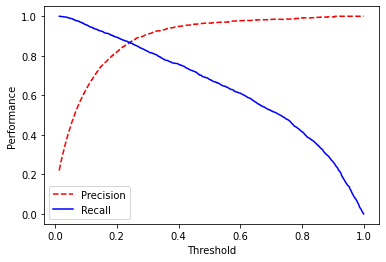

In [ ]:
# Threshold-PR curve
train_loss, y_true, y_prob = trainer.eval_step(dataloader=train_dataloader)
precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(), y_prob.ravel())
plt.plot(thresholds, precisions[:-1], "r--", label="Precision")
plt.plot(thresholds, recalls[:-1], "b-", label="Recall")
plt.ylabel("Performance")
plt.xlabel("Threshold")
plt.legend(loc="best")

In [ ]:
# Determining the best threshold
def find_best_threshold(y_true, y_prob):
    """Find the best threshold for maximum F1."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1s = (2 * precisions * recalls) / (precisions + recalls)
    return thresholds[np.argmax(f1s)]

In [ ]:
# Best threshold for f1
threshold = find_best_threshold(y_true.ravel(), y_prob.ravel())
threshold

0.26368636

In [ ]:
# Determine predictions using threshold
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.7900997715357903,
  "recall": 0.6081370449678801,
  "f1": 0.6689471654738494
}


In [ ]:
# Save artifacts
dir = Path("cnn")
dir.mkdir(parents=True, exist_ok=True)
tokenizer.save(fp=Path(dir, "tokenzier.json"))
label_encoder.save(fp=Path(dir, "label_encoder.json"))
torch.save(best_model.state_dict(), Path(dir, "model.pt"))
with open(Path(dir, "performance.json"), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

### Inference

In [ ]:
# Load artifacts
device = torch.device("cpu")
tokenizer = Tokenizer.load(fp=Path(dir, "tokenzier.json"))
label_encoder = LabelEncoder.load(fp=Path(dir, "label_encoder.json"))
model = CNN(
    embedding_dim=embedding_dim, vocab_size=vocab_size,
    num_filters=num_filters, filter_sizes=filter_sizes,
    hidden_dim=hidden_dim, dropout_p=dropout_p,
    num_classes=num_classes)
model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
model.to(device)

CNN(
  (embeddings): Embedding(39, 128, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    (1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (3): Conv1d(128, 128, kernel_size=(4,), stride=(1,))
    (4): Conv1d(128, 128, kernel_size=(5,), stride=(1,))
    (5): Conv1d(128, 128, kernel_size=(6,), stride=(1,))
    (6): Conv1d(128, 128, kernel_size=(7,), stride=(1,))
    (7): Conv1d(128, 128, kernel_size=(8,), stride=(1,))
    (8): Conv1d(128, 128, kernel_size=(9,), stride=(1,))
    (9): Conv1d(128, 128, kernel_size=(10,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1280, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=34, bias=True)
)

In [ ]:
# Initialize trainer
trainer = Trainer(model=model, device=device)

In [ ]:
# Dataloader
text = "Transfer learning with BERT for self-supervised learning"
X = np.array(tokenizer.texts_to_sequences([preprocess(text)]))
y_filler = label_encoder.encode([np.array([label_encoder.classes[0]]*len(X))])
dataset = CNNTextDataset(
    X=X, y=y_filler, max_filter_size=max(filter_sizes))
dataloader = dataset.create_dataloader(
    batch_size=batch_size)

In [ ]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])
label_encoder.decode(y_pred)

[['natural-language-processing',
  'self-supervised-learning',
  'transfer-learning',
  'transformers']]

<u><i>limitations</i></u>:
- *representation*: embeddings are not contextual.
- *architecture*: extracting signal from encoded inputs is limited by filter widths.

Since we're dealing with simple architectures and fast training times, it's a good opportunity to explore tuning and experiment with k-fold cross validation to properly reach any conclusions about performance.

## RNN w/ Embeddings

<u>*motivation*</u>: let's see if processing our embedded tokens in a sequential fashion using [recurrent neural networks (RNNs)](https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/13_Recurrent_Neural_Networks.ipynb) can yield better performance. 

### Set up

In [ ]:
# Set seeds
set_seeds()

In [ ]:
# Get data splits
preprocessed_df = df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)

In [ ]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tags": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tags": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tags": label_encoder.decode(y_test)})

In [ ]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cuda


### Tokenizer

In [ ]:
# Tokenize
char_level = True
tokenizer = Tokenizer(char_level=char_level)
tokenizer.fit_on_texts(texts=X_train)
vocab_size = len(tokenizer)
print ("X tokenizer:\n"
    f"  {tokenizer}")

X tokenizer:
  <Tokenizer(num_tokens=39)>


In [ ]:
tokenizer.token_to_index

{' ': 2,
 '0': 29,
 '1': 31,
 '2': 26,
 '3': 32,
 '4': 35,
 '5': 33,
 '6': 37,
 '7': 38,
 '8': 36,
 '9': 34,
 '<PAD>': 0,
 '<UNK>': 1,
 'a': 6,
 'b': 20,
 'c': 12,
 'd': 14,
 'e': 3,
 'f': 19,
 'g': 15,
 'h': 18,
 'i': 4,
 'j': 28,
 'k': 23,
 'l': 11,
 'm': 16,
 'n': 5,
 'o': 10,
 'p': 13,
 'q': 30,
 'r': 8,
 's': 9,
 't': 7,
 'u': 17,
 'v': 21,
 'w': 24,
 'x': 25,
 'y': 22,
 'z': 27}

In [ ]:
# Convert texts to sequences of indices
X_train = np.array(tokenizer.texts_to_sequences(X_train))
X_val = np.array(tokenizer.texts_to_sequences(X_val))
X_test = np.array(tokenizer.texts_to_sequences(X_test))
preprocessed_text = tokenizer.sequences_to_texts([X_train[0]])[0]
print ("Text to indices:\n"
    f"  (preprocessed) → {preprocessed_text}\n"
    f"  (tokenized) → {X_train[0]}")

Text to indices:
  (preprocessed) → google stock price prediction using alpha vantage api predict google stock price
  (tokenized) → [15 10 10 15 11  3  2  9  7 10 12 23  2 13  8  4 12  3  2 13  8  3 14  4
 12  7  4 10  5  2 17  9  4  5 15  2  6 11 13 18  6  2 21  6  5  7  6 15
  3  2  6 13  4  2 13  8  3 14  4 12  7  2 15 10 10 15 11  3  2  9  7 10
 12 23  2 13  8  4 12  3]


### Data imbalance

In [ ]:
# Class weights
counts = np.bincount([label_encoder.class_to_index[class_] for class_ in all_tags])
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print ("class counts:\n"
    f"  {counts}\n"
    "class weights:\n"
    f"  {class_weights}")

class counts:
  [120  41 388 106  41  75  34  73  51  78  64  51  55  93  51 424  33  69
  30  51 258  32  49  59  57  60  48  40 213  40  34  46 196  39]
class weights:
  {0: 0.008333333333333333, 1: 0.024390243902439025, 2: 0.002577319587628866, 3: 0.009433962264150943, 4: 0.024390243902439025, 5: 0.013333333333333334, 6: 0.029411764705882353, 7: 0.0136986301369863, 8: 0.0196078431372549, 9: 0.01282051282051282, 10: 0.015625, 11: 0.0196078431372549, 12: 0.01818181818181818, 13: 0.010752688172043012, 14: 0.0196078431372549, 15: 0.0023584905660377358, 16: 0.030303030303030304, 17: 0.014492753623188406, 18: 0.03333333333333333, 19: 0.0196078431372549, 20: 0.003875968992248062, 21: 0.03125, 22: 0.02040816326530612, 23: 0.01694915254237288, 24: 0.017543859649122806, 25: 0.016666666666666666, 26: 0.020833333333333332, 27: 0.025, 28: 0.004694835680751174, 29: 0.025, 30: 0.029411764705882353, 31: 0.021739130434782608, 32: 0.00510204081632653, 33: 0.02564102564102564}


### Datasets

In [ ]:
class RNNTextDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, len(X), y]

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        batch = np.array(batch, dtype=object)
        X = batch[:, 0]
        seq_lens = batch[:, 1]
        y = np.stack(batch[:, 2], axis=0)

        # Pad inputs
        X = pad_sequences(sequences=X)

        # Cast
        X = torch.LongTensor(X.astype(np.int32))
        seq_lens = torch.LongTensor(seq_lens.astype(np.int32))
        y = torch.FloatTensor(y.astype(np.int32))

        return X, seq_lens, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self,
            batch_size=batch_size,
            collate_fn=self.collate_fn,
            shuffle=shuffle,
            drop_last=drop_last,
            pin_memory=True)

In [ ]:
# Create datasets
batch_size = 128
train_dataset = RNNTextDataset(
    X=X_train, y=y_train)
val_dataset = RNNTextDataset(
    X=X_val, y=y_val)
test_dataset = RNNTextDataset(
    X=X_test, y=y_test)
print ("Data splits:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {train_dataset[0][0]}\n"
    f"  seq_len: {train_dataset[0][1]}\n"
    f"  y: {train_dataset[0][2]}")

Data splits:
  Train dataset:<Dataset(N=1001)>
  Val dataset: <Dataset(N=218)>
  Test dataset: <Dataset(N=220)>
Sample point:
  X: [15 10 10 15 11  3  2  9  7 10 12 23  2 13  8  4 12  3  2 13  8  3 14  4
 12  7  4 10  5  2 17  9  4  5 15  2  6 11 13 18  6  2 21  6  5  7  6 15
  3  2  6 13  4  2 13  8  3 14  4 12  7  2 15 10 10 15 11  3  2  9  7 10
 12 23  2 13  8  4 12  3]
  seq_len: 80
  y: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Create dataloaders
train_dataloader = train_dataset.create_dataloader(
    batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(
    batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(
    batch_size=batch_size)
batch_X, batch_seq_lens, batch_y = next(iter(train_dataloader))
print (batch_X.shape)
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  seq_lens: {list(batch_seq_lens.size())}\n"
    f"  y: {list(batch_y.size())}")

torch.Size([128, 197])
Sample batch:
  X: [128, 197]
  seq_lens: [128]
  y: [128, 34]


### Model

We'll be using a recurrent neural network to process our embedded tokens one at a time (sequentially). If you're not familiar with RNNs be sure to check out the [RNN lesson](https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/13_Recurrent_Neural_Networks.ipynb) *where* we walkthrough every component of the architecture.

<div align="left">
<img src="https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/images/basics/rnn/vanilla.png" width="500">
</div>

RNN forward pass for a single time step $X_t$:

$h_t = tanh(W_{hh}h_{t-1} + W_{xh}X_t+b_h)$

*where*:
* $W_{hh}$ = hidden units weights| $\in \mathbb{R}^{HXH}$ ($H$ is the hidden dim)
* $h_{t-1}$ = previous timestep's hidden state $\in \mathbb{R}^{NXH}$
* $W_{xh}$ = input weights| $\in \mathbb{R}^{EXH}$
* $X_t$ = input at time step t | $\in \mathbb{R}^{NXE}$ ($N$ is the batch size, $E$ is the embedding dim)
* $b_h$ = hidden units bias $\in \mathbb{R}^{HX1}$
* $h_t$ = output from RNN for timestep $t$

In [ ]:
# Arguments
embedding_dim = 128
rnn_hidden_dim = 128
hidden_dim = 128
dropout_p = 0.5

In [ ]:
def gather_last_relevant_hidden(hiddens, seq_lens):
    """Extract and collect the last relevant 
    hidden state based on the sequence length."""
    seq_lens = seq_lens.long().detach().cpu().numpy() - 1
    out = []
    for batch_index, column_index in enumerate(seq_lens):
        out.append(hiddens[batch_index, column_index])
    return torch.stack(out)

In [ ]:
class RNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, rnn_hidden_dim,
                 hidden_dim, dropout_p, num_classes, padding_idx=0):
        super(RNN, self).__init__()
        
        # Initialize embeddings
        self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                       num_embeddings=vocab_size,
                                       padding_idx=padding_idx)
        
        # RNN
        self.rnn = nn.GRU(embedding_dim, rnn_hidden_dim, 
                          batch_first=True, bidirectional=True)
     
        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(rnn_hidden_dim*2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs):
        # Inputs
        x_in, seq_lens = inputs

        # Embed
        x_in = self.embeddings(x_in)
            
        # Rnn outputs
        out, h_n = self.rnn(x_in)
        z = gather_last_relevant_hidden(hiddens=out, seq_lens=seq_lens)

        # FC layers
        z = self.fc1(z)
        z = self.dropout(z)
        z = self.fc2(z)

        return z

In [ ]:
# Initialize model
model = RNN(
    embedding_dim=embedding_dim, vocab_size=vocab_size,
    rnn_hidden_dim=rnn_hidden_dim, hidden_dim=hidden_dim, 
    dropout_p=dropout_p, num_classes=num_classes)
model = model.to(device)
print (model.named_parameters)

<bound method Module.named_parameters of RNN(
  (embeddings): Embedding(39, 128, padding_idx=0)
  (rnn): GRU(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=34, bias=True)
)>


### Training

In [ ]:
# Arguments
lr = 2e-3
num_epochs = 200
patience = 10

In [ ]:
# Define loss
class_weights_tensor = torch.Tensor(np.array(list(class_weights.values())))
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)

In [ ]:
# Define optimizer & scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5)

In [ ]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn, 
    optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Train
best_model = trainer.train(
    num_epochs, patience, train_dataloader, val_dataloader)

Epoch: 1 | train_loss: 0.00801, val_loss: 0.00315, lr: 2.00E-03, _patience: 10
Epoch: 2 | train_loss: 0.00389, val_loss: 0.00318, lr: 2.00E-03, _patience: 9
Epoch: 3 | train_loss: 0.00328, val_loss: 0.00280, lr: 2.00E-03, _patience: 10
Epoch: 4 | train_loss: 0.00301, val_loss: 0.00277, lr: 2.00E-03, _patience: 10
Epoch: 5 | train_loss: 0.00293, val_loss: 0.00268, lr: 2.00E-03, _patience: 10
Epoch: 6 | train_loss: 0.00285, val_loss: 0.00267, lr: 2.00E-03, _patience: 10
Epoch: 7 | train_loss: 0.00282, val_loss: 0.00263, lr: 2.00E-03, _patience: 10
Epoch: 8 | train_loss: 0.00277, val_loss: 0.00262, lr: 2.00E-03, _patience: 10
Epoch: 9 | train_loss: 0.00274, val_loss: 0.00261, lr: 2.00E-03, _patience: 10
Epoch: 10 | train_loss: 0.00271, val_loss: 0.00261, lr: 2.00E-03, _patience: 10
Epoch: 11 | train_loss: 0.00271, val_loss: 0.00260, lr: 2.00E-03, _patience: 10
Epoch: 12 | train_loss: 0.00269, val_loss: 0.00260, lr: 2.00E-03, _patience: 10
Epoch: 13 | train_loss: 0.00267, val_loss: 0.00260

### Evaluation

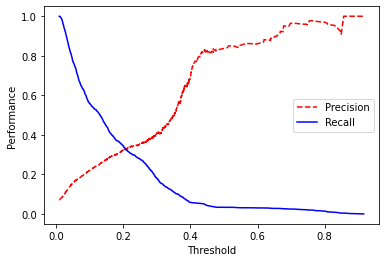

In [ ]:
# Threshold-PR curve
train_loss, y_true, y_prob = trainer.eval_step(dataloader=train_dataloader)
precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(), y_prob.ravel())
plt.plot(thresholds, precisions[:-1], "r--", label="Precision")
plt.plot(thresholds, recalls[:-1], "b-", label="Recall")
plt.ylabel("Performance")
plt.xlabel("Threshold")
plt.legend(loc='best')

In [ ]:
# Best threshold for f1
threshold = find_best_threshold(y_true.ravel(), y_prob.ravel())
threshold

0.15385097

In [ ]:
# Determine predictions using threshold
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.2004498464795256,
  "recall": 0.4068522483940043,
  "f1": 0.22600151322505954
}


In [ ]:
# Save artifacts
dir = Path("rnn")
dir.mkdir(parents=True, exist_ok=True)
tokenizer.save(fp=Path(dir, "tokenzier.json"))
label_encoder.save(fp=Path(dir, "label_encoder.json"))
torch.save(best_model.state_dict(), Path(dir, "model.pt"))
with open(Path(dir, "performance.json"), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

### Inference

In [ ]:
# Initialize model
model = RNN(
    embedding_dim=embedding_dim, vocab_size=vocab_size,
    rnn_hidden_dim=rnn_hidden_dim, hidden_dim=hidden_dim, 
    dropout_p=dropout_p, num_classes=num_classes)
model = model.to(device)
print (f"Model:\n{model.named_parameters}")

Model:
<bound method Module.named_parameters of RNN(
  (embeddings): Embedding(39, 128, padding_idx=0)
  (rnn): GRU(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=34, bias=True)
)>


In [ ]:
# Load artifacts
device = torch.device("cpu")
tokenizer = Tokenizer.load(fp=Path(dir, "tokenzier.json"))
label_encoder = LabelEncoder.load(fp=Path(dir, "label_encoder.json"))
model = RNN(
    embedding_dim=embedding_dim, vocab_size=vocab_size,
    rnn_hidden_dim=rnn_hidden_dim, hidden_dim=hidden_dim, 
    dropout_p=dropout_p, num_classes=num_classes)
model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
model.to(device)

RNN(
  (embeddings): Embedding(39, 128, padding_idx=0)
  (rnn): GRU(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=34, bias=True)
)

In [ ]:
# Initialize trainer
trainer = Trainer(model=model, device=device)

In [ ]:
# Dataloader
text = "Transfer learning with BERT for self-supervised learning"
X = np.array(tokenizer.texts_to_sequences([preprocess(text)]))
y_filler = label_encoder.encode([np.array([label_encoder.classes[0]]*len(X))])
dataset = RNNTextDataset(X=X, y=y_filler)
dataloader = dataset.create_dataloader(batch_size=batch_size)

In [ ]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])
label_encoder.decode(y_pred)

[[]]

<u>*limitation*</u>: since we're using character embeddings our encoded sequences are quite long (>100), the RNNs may potentially be suffering from memory issues. We also can't process our tokens in parallel because we're restricted by sequential processing.

> Don't be afraid to experiment with stacking models if they're able to extract unique signal from your encoded data, for example applying CNNs on the outputs from the RNN (outputs from all tokens, not just last relevant one).

## Transformers w/ Contextual Embeddings

<u><i>motivation</i></u>:
- *representation*: we want better representation for our input tokens via contextual embeddings where the token representation is based on the specific neighboring tokens. We can also use sub-word tokens, as opposed to character tokens, since they can hold more meaningful representation for many of our keywords, prefixes, suffixes, etc.
- *architecture*: we want to use [Transformers](https://www.youtube.com/watch?v=LwV7LKunDbs) to attend (in parallel) to all the tokens in our input, as opposed to being limited by filter spans (CNNs) or memory issues from sequential processing (RNNs).

<a href="https://miro.medium.com/max/2880/1*BHzGVskWGS_3jEcYYi6miQ.png" target="_blank"><img width="400px" src="https://miro.medium.com/max/2880/1*BHzGVskWGS_3jEcYYi6miQ.png"></a>

### Set up

In [ ]:
# Set seeds
set_seeds()

In [ ]:
# Get data splits
preprocessed_df = df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)

In [ ]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tags": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tags": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tags": label_encoder.decode(y_test)})

In [ ]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cuda


### Tokenizer

We'll be using the [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer) to tokenize our input text in to sub-word tokens.

In [ ]:
from transformers import DistilBertTokenizer
from transformers import BertTokenizer

In [ ]:
# Load tokenizer and model
# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
vocab_size = len(tokenizer)
print (vocab_size)

31090


In [ ]:
# Tokenize inputs
encoded_input = tokenizer(X_train.tolist(), return_tensors="pt", padding=True)
X_train_ids = encoded_input["input_ids"]
X_train_masks = encoded_input["attention_mask"]
print (X_train_ids.shape, X_train_masks.shape)
encoded_input = tokenizer(X_val.tolist(), return_tensors="pt", padding=True)
X_val_ids = encoded_input["input_ids"]
X_val_masks = encoded_input["attention_mask"]
print (X_val_ids.shape, X_val_masks.shape)
encoded_input = tokenizer(X_test.tolist(), return_tensors="pt", padding=True)
X_test_ids = encoded_input["input_ids"]
X_test_masks = encoded_input["attention_mask"]
print (X_test_ids.shape, X_test_masks.shape)

torch.Size([1001, 40]) torch.Size([1001, 40])
torch.Size([218, 38]) torch.Size([218, 38])
torch.Size([220, 41]) torch.Size([220, 41])


In [ ]:
# Decode
print (f"{X_train_ids[0]}\n{tokenizer.decode(X_train_ids[0])}")

tensor([  102, 13387,  5426,  4048,  3838,   487,  6010,  3310, 14647, 13419,
         3754, 13387,  5426,  4048,   103,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
[CLS] google stock price prediction using alpha vantage api predict google stock price [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
# Sub-word tokens
print (tokenizer.convert_ids_to_tokens(ids=X_train_ids[0]))

['[CLS]', 'google', 'stock', 'price', 'prediction', 'using', 'alpha', 'van', '##tage', 'api', 'predict', 'google', 'stock', 'price', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


### Data imbalance

In [ ]:
# Class weights
counts = np.bincount([label_encoder.class_to_index[class_] for class_ in all_tags])
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print ("class counts:\n"
    f"  {counts}\n\n"
    "class weights:\n"
    f"  {class_weights}")

class counts:
  [120  41 388 106  41  75  34  73  51  78  64  51  55  93  51 424  33  69
  30  51 258  32  49  59  57  60  48  40 213  40  34  46 196  39]

class weights:
  {0: 0.008333333333333333, 1: 0.024390243902439025, 2: 0.002577319587628866, 3: 0.009433962264150943, 4: 0.024390243902439025, 5: 0.013333333333333334, 6: 0.029411764705882353, 7: 0.0136986301369863, 8: 0.0196078431372549, 9: 0.01282051282051282, 10: 0.015625, 11: 0.0196078431372549, 12: 0.01818181818181818, 13: 0.010752688172043012, 14: 0.0196078431372549, 15: 0.0023584905660377358, 16: 0.030303030303030304, 17: 0.014492753623188406, 18: 0.03333333333333333, 19: 0.0196078431372549, 20: 0.003875968992248062, 21: 0.03125, 22: 0.02040816326530612, 23: 0.01694915254237288, 24: 0.017543859649122806, 25: 0.016666666666666666, 26: 0.020833333333333332, 27: 0.025, 28: 0.004694835680751174, 29: 0.025, 30: 0.029411764705882353, 31: 0.021739130434782608, 32: 0.00510204081632653, 33: 0.02564102564102564}


### Datasets

In [ ]:
class TransformerTextDataset(torch.utils.data.Dataset):
    def __init__(self, ids, masks, targets):
        self.ids = ids
        self.masks = masks
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        ids = torch.tensor(self.ids[index], dtype=torch.long)
        masks = torch.tensor(self.masks[index], dtype=torch.long)
        targets = torch.FloatTensor(self.targets[index])
        return ids, masks, targets

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self,
            batch_size=batch_size,
            shuffle=shuffle,
            drop_last=drop_last,
            pin_memory=False)

In [ ]:
# Create datasets
train_dataset = TransformerTextDataset(ids=X_train_ids, masks=X_train_masks, targets=y_train)
val_dataset = TransformerTextDataset(ids=X_val_ids, masks=X_val_masks, targets=y_val)
test_dataset = TransformerTextDataset(ids=X_test_ids, masks=X_test_masks, targets=y_test)
print ("Data splits:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  ids: {train_dataset[0][0]}\n"
    f"  masks: {train_dataset[0][1]}\n"
    f"  targets: {train_dataset[0][2]}")

Data splits:
  Train dataset:<Dataset(N=1001)>
  Val dataset: <Dataset(N=218)>
  Test dataset: <Dataset(N=220)>
Sample point:
  ids: tensor([  102, 13387,  5426,  4048,  3838,   487,  6010,  3310, 14647, 13419,
         3754, 13387,  5426,  4048,   103,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
  masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  targets: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cpu')


In [ ]:
# Create dataloaders
batch_size = 128
train_dataloader = train_dataset.create_dataloader(
    batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(
    batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(
    batch_size=batch_size)
batch = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  ids: {batch[0].size()}\n"
    f"  masks: {batch[1].size()}\n"
    f"  targets: {batch[2].size()}")

Sample batch:
  ids: torch.Size([128, 40])
  masks: torch.Size([128, 40])
  targets: torch.Size([128, 34])


### Model

We're going to use a pretrained [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) to act as a feature extractor. We'll only use the encoder to receive sequential and pooled outputs (`is_decoder=False` is default).

In [ ]:
from transformers import BertModel

In [ ]:
# transformer = BertModel.from_pretrained("distilbert-base-uncased")
# embedding_dim = transformer.config.dim
transformer = BertModel.from_pretrained("allenai/scibert_scivocab_uncased")
embedding_dim = transformer.config.hidden_size

In [ ]:
class Transformer(nn.Module):
    def __init__(self, transformer, dropout_p, embedding_dim, num_classes):
        super(Transformer, self).__init__()
        self.transformer = transformer
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)
    
    def forward(self, inputs):
        ids, masks = inputs
        seq, pool = self.transformer(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z

> We decided to work with the pooled output, but we could have just as easily worked with the sequential output (encoder representation for each sub-token) and applied a CNN (or other decoder options) on top of it.

In [ ]:
# Initialize model
dropout_p = 0.5
model = Transformer(
    transformer=transformer, dropout_p=dropout_p,
    embedding_dim=embedding_dim, num_classes=num_classes)
model = model.to(device)
print (model.named_parameters)

<bound method Module.named_parameters of Transformer(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

### Training

In [ ]:
# Arguments
lr = 1e-4
num_epochs = 200
patience = 10

In [ ]:
# Define loss
class_weights_tensor = torch.Tensor(np.array(list(class_weights.values())))
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)

In [ ]:
# Define optimizer & scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5)

In [ ]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn, 
    optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Train
best_model = trainer.train(
    num_epochs, patience, train_dataloader, val_dataloader)

Epoch: 1 | train_loss: 0.00819, val_loss: 0.00485, lr: 1.00E-04, _patience: 10
Epoch: 2 | train_loss: 0.00440, val_loss: 0.00345, lr: 1.00E-04, _patience: 10
Epoch: 3 | train_loss: 0.00344, val_loss: 0.00296, lr: 1.00E-04, _patience: 10
Epoch: 4 | train_loss: 0.00309, val_loss: 0.00279, lr: 1.00E-04, _patience: 10
Epoch: 5 | train_loss: 0.00294, val_loss: 0.00274, lr: 1.00E-04, _patience: 10
Epoch: 6 | train_loss: 0.00291, val_loss: 0.00273, lr: 1.00E-04, _patience: 10
Epoch: 7 | train_loss: 0.00290, val_loss: 0.00273, lr: 1.00E-04, _patience: 10
Epoch: 8 | train_loss: 0.00288, val_loss: 0.00273, lr: 1.00E-04, _patience: 9
Epoch: 9 | train_loss: 0.00289, val_loss: 0.00273, lr: 1.00E-04, _patience: 8
Epoch: 10 | train_loss: 0.00289, val_loss: 0.00273, lr: 1.00E-04, _patience: 7
Epoch: 11 | train_loss: 0.00290, val_loss: 0.00273, lr: 1.00E-04, _patience: 10
Epoch: 12 | train_loss: 0.00289, val_loss: 0.00272, lr: 1.00E-04, _patience: 10
Epoch: 13 | train_loss: 0.00289, val_loss: 0.00272, 

### Evaluation

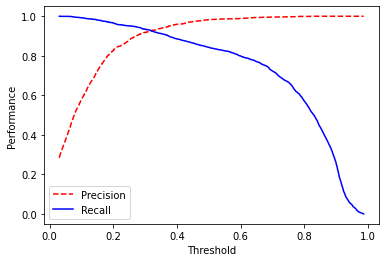

In [ ]:
# Threshold-PR curve
train_loss, y_true, y_prob = trainer.eval_step(dataloader=train_dataloader)
precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(), y_prob.ravel())
plt.plot(thresholds, precisions[:-1], "r--", label="Precision")
plt.plot(thresholds, recalls[:-1], "b-", label="Recall")
plt.ylabel("Performance")
plt.xlabel("Threshold")
plt.legend(loc='best')

In [ ]:
# Best threshold for f1
threshold = find_best_threshold(y_true.ravel(), y_prob.ravel())
threshold

0.31417453

In [ ]:
# Determine predictions using threshold
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.7348397345183624,
  "recall": 0.6595289079229122,
  "f1": 0.682945515558344
}


In [ ]:
# Save artifacts
dir = Path("transformers")
dir.mkdir(parents=True, exist_ok=True)
label_encoder.save(fp=Path(dir, "label_encoder.json"))
torch.save(best_model.state_dict(), Path(dir, "model.pt"))
with open(Path(dir, "performance.json"), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

### Inference

In [ ]:
# Load artifacts
device = torch.device("cpu")
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
label_encoder = LabelEncoder.load(fp=Path(dir, "label_encoder.json"))
transformer = BertModel.from_pretrained("allenai/scibert_scivocab_uncased")
embedding_dim = transformer.config.hidden_size
model = Transformer(
    transformer=transformer, dropout_p=dropout_p,
    embedding_dim=embedding_dim, num_classes=num_classes)
model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
model.to(device);

In [ ]:
# Initialize trainer
trainer = Trainer(model=model, device=device)

In [ ]:
# Dataloader
text = "Transfer learning with BERT for self-supervised learning"
X = preprocess(text)
encoded_input = tokenizer(X, return_tensors="pt", padding=True).to(torch.device("cpu"))
ids = encoded_input["input_ids"]
masks = encoded_input["attention_mask"]
y_filler = label_encoder.encode([np.array([label_encoder.classes[0]] * len(X))])
dataset = TransformerTextDataset(ids=ids, masks=masks, targets=y_filler)
dataloader = dataset.create_dataloader(batch_size=int(batch_size))

In [ ]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])
label_encoder.decode(y_pred)

[['transfer-learning']]

### Visualize

Let's visualize the self-attention weights from each of the attention heads in the encoder.

In [ ]:
import sys
!rm -r bertviz_repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not "bertviz_repo" in sys.path:
  sys.path += ["bertviz_repo"]

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1318, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 1318 (delta 68), reused 67 (delta 30), pack-reused 1203
Receiving objects: 100% (1318/1318), 213.58 MiB | 29.23 MiB/s, done.
Resolving deltas: 100% (831/831), done.


In [ ]:
from bertviz import head_view

In [ ]:
print (ids)
print (tokenizer.batch_decode(ids))

tensor([[  102,  2268,  1904, 24921,  1968, 13749,  1904,   103]],
       device='cpu')
['[CLS] transfer learning bert self supervised learning [SEP]']


In [ ]:
# Get encoder attentions
seq, pool, attn = model.transformer(input_ids=ids, attention_mask=masks, output_attentions=True)

In [ ]:
print (len(attn)) # 12 attention layers (heads)
print (attn[0].shape)

12
torch.Size([1, 12, 8, 8])


In [ ]:
# HTML set up
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [ ]:
# Visualize self-attention weights
call_html()
tokens = tokenizer.convert_ids_to_tokens(ids[0])
head_view(attention=attn, tokens=tokens)

<IPython.core.display.Javascript object>

## Tradeoffs

We're going to go with the embeddings via CNN approach and optimize it because performance is quite similar to the contextualized embeddings via transformers approach but at much lower cost.

In [ ]:
# Performance
with open(Path("cnn", "performance.json"), "r") as fp:
    cnn_performance = json.load(fp)
with open(Path("transformers", "performance.json"), "r") as fp:
    transformers_performance = json.load(fp)
print (f'CNN: f1 = {cnn_performance["f1"]}')
print (f'Transformer: f1 = {transformers_performance["f1"]}')

CNN: f1 = 0.6689471654738494
Transformer: f1 = 0.682945515558344


This was just one run on one split so you'll want to experiment with k-fold cross validation to properly reach any conclusions about performance. Also make sure you take the time to tune these baselines since their training periods are quite fast (we can achieve f1 of 0.7 with just a bit of tuning for both CNN / Transformers). We'll cover hyperparameter tuning in a few lessons so you can replicate the process here on your own time. We should also benchmark on other important metrics as we iterate, not just precision and recall.

In [ ]:
# Size
print (f'CNN: {Path("cnn", "model.pt").stat().st_size/1000000:.1f} MB')
print (f'Transformer: {Path("transformers", "model.pt").stat().st_size/1000000:.1f} MB')

CNN: 4.3 MB
Transformer: 439.9 MB


> We'll consider other tradeoffs such as maintenance overhead, behavioral test performances, etc. as we develop.

## Evaluation

So far we've been evaluating our models by determing the overall precision, recall and f1 scores. But since performance is one of the key decision making factors when comparing different models, we should have even more nuanced evaluation strategies.

- Overall metrics
- Per-class (tag) metrics
- Confusion matrix sample analysis
- Slice metrics

In [ ]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [ ]:
# Data to evaluate
device = torch.device("cuda")
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
trainer = Trainer(model=model.to(device), device=device, loss_fn=loss_fn)
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

### Overall metrics

In [ ]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_true))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.7348397345183624,
    "recall": 0.6595289079229122,
    "f1": 0.682945515558344,
    "num_samples": 220.0
}


### Per-class metrics

In [ ]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(label_encoder.classes):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [ ]:
# Metrics for a specific class
tag = "transformers"
print (json.dumps(metrics["class"][tag], indent=2))

{
  "precision": 0.6785714285714286,
  "recall": 0.6785714285714286,
  "f1": 0.6785714285714286,
  "num_samples": 28.0
}


### Confusion matric sample analysis

- True positives: learn about where our model performs well.
- False positives: potentially identify samples which may need to be relabeled.
- False negatives: identify the model's less performant areas to oversample later.

> It's a good to have our FP/FN samples feed back into our annotation pipelines in the event we want to fix their labels and have those changes be reflected everywhere.

In [ ]:
# TP, FP, FN samples
index = label_encoder.class_to_index[tag]
tp, fp, fn = [], [], []
for i in range(len(y_test)):
    true = y_test[i][index]
    pred = y_pred[i][index]
    if true and pred:
        tp.append(i)
    elif not true and pred:
        fp.append(i)
    elif true and not pred:
        fn.append(i)

In [ ]:
print (tp)
print (fp)
print (fn)

[12, 24, 31, 49, 54, 58, 65, 89, 104, 122, 127, 148, 149, 152, 165, 172, 184, 198, 201]
[46, 73, 85, 92, 119, 130, 144, 169, 211]
[22, 27, 36, 66, 90, 135, 154, 200, 212]


In [ ]:
index = tp[0]
print (X_test[index])
print (f"true: {label_encoder.decode([y_test[index]])[0]}")
print (f"pred: {label_encoder.decode([y_pred[index]])[0]}\n")

haystack neural question answering scale transformers scale question answering search
true: ['huggingface', 'natural-language-processing', 'question-answering', 'transformers']
pred: ['huggingface', 'natural-language-processing', 'question-answering', 'transformers']



In [ ]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))

In [ ]:
@widgets.interact(tag=list(sorted_tags_by_f1.keys()))
def display_tag_analysis(tag='transformers'):
    # Performance
    print (json.dumps(metrics["class"][tag], indent=2))
    
    # TP, FP, FN samples
    index = label_encoder.class_to_index[tag]
    tp, fp, fn = [], [], []
    for i in range(len(y_test)):
        true = y_test[i][index]
        pred = y_pred[i][index]
        if true and pred:
            tp.append(i)
        elif not true and pred:
            fp.append(i)
        elif true and not pred:
            fn.append(i)
            
    # Samples
    num_samples = 3
    if len(tp): 
        print ("\n=== True positives ===")
        for i in tp[:num_samples]:        
            print (f"  {X_test[i]}")
            print (f"    true: {label_encoder.decode([y_test[i]])[0]}")
            print (f"    pred: {label_encoder.decode([y_pred[i]])[0]}\n")
    if len(fp): 
        print ("=== False positives === ")
        for i in fp[:num_samples]:        
            print (f"  {X_test[i]}")
            print (f"    true: {label_encoder.decode([y_test[i]])[0]}")
            print (f"    pred: {label_encoder.decode([y_pred[i]])[0]}\n")
    if len(fn): 
        print ("=== False negatives ===")
        for i in fn[:num_samples]:        
            print (f"  {X_test[i]}") 
            print (f"    true: {label_encoder.decode([y_test[i]])[0]}")
            print (f"    pred: {label_encoder.decode([y_pred[i]])[0]}\n")

interactive(children=(Dropdown(description='tag', index=17, options=('transfer-learning', 'graphs', 'time-seri…

> It's a really good idea to do this kind of analysis using our rule-based approach to catch really obvious labeling errors.

### Slice metrics

Evaluate performance on key slices of data that goes beyond class-level metrics.

In [ ]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [ ]:
@slicing_function()
def cv_transformers(x):
    """Projects with the `computer-vision` and `transformers` tags."""
    return all(tag in x.tags for tag in ["computer-vision", "transformers"])

In [ ]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 7  # less than 7 words

In [ ]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tags"]].head()

100%|██████████| 220/220 [00:00<00:00, 15152.09it/s]


,text,tags
6,autokeras automl library deep learning,[keras]
50,tune sklearn scikit learn api raytune,[scikit-learn]
146,g simclr tensorflow implementation g simclr,"[computer-vision, self-supervised-learning, te..."


We can define even more slicing functions and create a slices record array using the [`PandasSFApplier`](https://snorkel.readthedocs.io/en/v0.9.6/packages/_autosummary/slicing/snorkel.slicing.PandasSFApplier.html). The slices array has N (# of data points) items and each item has S (# of slicing functions) items, indicating whether that data point is part of that slice. Think of this record array as a masking layer for each slicing function on our data.

In [ ]:
# Slices
slicing_functions = [cv_transformers, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 220/220 [00:00<00:00, 24033.00it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

If our task was multiclass instead of multilabel, we could've used [snorkel.analysis.Scorer](https://snorkel.readthedocs.io/en/v0.9.1/packages/_autosummary/analysis/snorkel.analysis.Scorer.html) to retrieve our slice metrics. But we've implemented a naive version for our multilabel task based on it.

In [ ]:
# Score slices
metrics["slices"] = {}
metrics["slices"]["class"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):  
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"]["class"][slice_name] = {}
        metrics["slices"]["class"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"]["class"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"]["class"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"]["class"][slice_name]["num_samples"] = len(y_true[mask])

In [ ]:
# Weighted overall slice metrics
metrics["slices"]["overall"] = {}
for metric in ["precision", "recall", "f1"]:
    metrics["slices"]["overall"][metric] = np.mean(
        list(
            itertools.chain.from_iterable(
                [
                    [metrics["slices"]["class"][slice_name][metric]]
                    * metrics["slices"]["class"][slice_name]["num_samples"]
                    for slice_name in metrics["slices"]["class"]
                ]
            )
        )
    )

In [ ]:
print(json.dumps(metrics["slices"], indent=2))

{
  "class": {
    "cv_transformers": {
      "precision": 1.0,
      "recall": 0.75,
      "f1": 0.8571428571428571,
      "num_samples": 1
    },
    "short_text": {
      "precision": 0.6666666666666666,
      "recall": 0.8,
      "f1": 0.7272727272727272,
      "num_samples": 3
    }
  },
  "overall": {
    "precision": 0.7499999999999999,
    "recall": 0.7875000000000001,
    "f1": 0.7597402597402596
  }
}


> In our [testing lesson](https://madewithml.com/courses/mlops/testing/), we'll cover another way to evaluate our model known as [behavioral testing](https://madewithml.com/courses/mlops/testing/#behavioral-testing), which we'll also include as part of performance report.

## Experiment tracking

So far, we've been training and evaluating our different baselines but haven't really been tracking these experiments. We'll fix this by defining a proper process for experiment tracking which we'll use for all future experiments (including hyperparameter optimization). There are many options for experiment tracking but we're going to use [MLFlow](https://mlflow.org/) (100% free and [open-source](https://github.com/mlflow/mlflow)) because it has all the functionality we'll need (and [growing integration support](https://medium.com/pytorch/mlflow-and-pytorch-where-cutting-edge-ai-meets-mlops-1985cf8aa789)). We can run MLFlow on our own servers and databases so there are no storage cost / limitations, making it one of the most popular options and is used by Microsoft, Facebook, Databricks and others. You can also set up your own Tracking servers to synchronize runs amongst multiple team members collaborating on the same task.

There are also several popular options such as a [Comet ML](https://www.comet.ml/site/) (Used by Google AI, HuggingFace, etc.) and [Weights and Biases](https://www.wandb.com/) (Used by Open AI, Toyota Research, etc.). These are fantastic tools that provide features like dashboards, seamless integration, hyperparameter search, reports and even [debugging](https://wandb.ai/latentspace/published-work/The-Science-of-Debugging-with-W-B-Reports--Vmlldzo4OTI3Ng)!

In [ ]:
!pip install mlflow pyngrok -q

In [ ]:
from argparse import Namespace
import mlflow
from pathlib import Path

In [ ]:
# Specify arguments
args = Namespace(
    char_level=True,
    filter_sizes=list(range(1, 11)),
    batch_size=64,
    embedding_dim=128, 
    num_filters=128,
    hidden_dim=128, 
    dropout_p=0.5,
    lr=2e-4,
    num_epochs=200,
    patience=10,
)

> When we move to Python scripts, we'll use the [Typer](https://typer.tiangolo.com/) package instead of argparse for a better CLI experience.

In [ ]:
# Set tracking URI
MODEL_REGISTRY = Path("experiments")
Path(MODEL_REGISTRY).mkdir(exist_ok=True) # create experiments dir
mlflow.set_tracking_uri("file://" + str(MODEL_REGISTRY.absolute()))

In [ ]:
!ls

### Training

We're going to log the training epoch metrics within our `Trainer`'s `train` function. 

In [ ]:
# Trainer (modified for experiment tracking)
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, 
                 optimizer=None, scheduler=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):
            # Step
            batch = [item.to(self.device) for item in batch]
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = torch.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                y_prob = self.model(inputs)

                # Store outputs
                y_probs.extend(y_prob)

        return np.vstack(y_probs)
    
    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Tracking
            mlflow.log_metrics(
                {"train_loss": train_loss, "val_loss": val_loss}, step=epoch
            )

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )

        return best_model, best_val_loss

And to make things simple, we'll encapsulate all the components for training into one function which returns all the artifacts we want to be able to track from our experiment. The input argument `args`contains all the parameters needed and it's nice to have it all organized under one variable so we can easily log it and tweak it for different experiments (we'll see this when we do hyperparameter optimization).

In [ ]:
def train_cnn(args, df):
    """Train a CNN using specific arguments."""

    # Set seeds
    set_seeds()

    # Get data splits
    preprocessed_df = df.copy()
    preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True)
    X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)
    num_classes = len(label_encoder)

    # Set device
    cuda = True
    device = torch.device("cuda" if (
        torch.cuda.is_available() and cuda) else "cpu")
    torch.set_default_tensor_type("torch.FloatTensor")
    if device.type == "cuda":
        torch.set_default_tensor_type("torch.cuda.FloatTensor")

    # Tokenize
    tokenizer = Tokenizer(char_level=args.char_level)
    tokenizer.fit_on_texts(texts=X_train)
    vocab_size = len(tokenizer)

    # Convert texts to sequences of indices
    X_train = np.array(tokenizer.texts_to_sequences(X_train))
    X_val = np.array(tokenizer.texts_to_sequences(X_val))
    X_test = np.array(tokenizer.texts_to_sequences(X_test))

    # Class weights
    counts = np.bincount([label_encoder.class_to_index[class_] for class_ in all_tags])
    class_weights = {i: 1.0/count for i, count in enumerate(counts)}

    # Create datasets
    train_dataset = CNNTextDataset(
        X=X_train, y=y_train, max_filter_size=max(args.filter_sizes))
    val_dataset = CNNTextDataset(
        X=X_val, y=y_val, max_filter_size=max(args.filter_sizes))
    test_dataset = CNNTextDataset(
        X=X_test, y=y_test, max_filter_size=max(args.filter_sizes))

    # Create dataloaders
    train_dataloader = train_dataset.create_dataloader(
        batch_size=args.batch_size)
    val_dataloader = val_dataset.create_dataloader(
        batch_size=args.batch_size)
    test_dataloader = test_dataset.create_dataloader(
        batch_size=args.batch_size)

    # Initialize model
    model = CNN(
        embedding_dim=args.embedding_dim, vocab_size=vocab_size,
        num_filters=args.num_filters, filter_sizes=args.filter_sizes,
        hidden_dim=args.hidden_dim, dropout_p=args.dropout_p,
        num_classes=num_classes)
    model = model.to(device)

    # Define loss
    class_weights_tensor = torch.Tensor(np.array(list(class_weights.values())))
    loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)

    # Define optimizer & scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=5)

    # Trainer module
    trainer = Trainer(
        model=model, device=device, loss_fn=loss_fn, 
        optimizer=optimizer, scheduler=scheduler)

    # Train
    best_model, best_val_loss = trainer.train(
        args.num_epochs, args.patience, train_dataloader, val_dataloader)

    # Best threshold for f1
    train_loss, y_true, y_prob = trainer.eval_step(dataloader=train_dataloader)
    precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(), y_prob.ravel())
    threshold = find_best_threshold(y_true.ravel(), y_prob.ravel())

    # Determine predictions using threshold
    test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
    y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

    # Evaluate (simple)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

    return {
        "args": args,
        "tokenizer": tokenizer,
        "label_encoder": label_encoder,
        "model": best_model,
        "performance": performance,
        "best_val_loss": best_val_loss,
    }

### Tracking

With MLFlow we need to first initialize an experiment and then you can do runs under that experiment.

In [ ]:
import tempfile

In [ ]:
# Set experiment
mlflow.set_experiment(experiment_name="baselines")

In [ ]:
def save_dict(d, filepath):
    """Save dict to a json file."""
    with open(filepath, "w") as fp:
        json.dump(d, indent=2, sort_keys=False, fp=fp)

In [ ]:
# Tracking
with mlflow.start_run(run_name="cnn") as run:

    # Train & evaluate
    artifacts = train_cnn(args=args, df=df)    
    
    # Log key metrics
    mlflow.log_metrics({"precision": artifacts["performance"]["overall"]["precision"]})
    mlflow.log_metrics({"recall": artifacts["performance"]["overall"]["recall"]})
    mlflow.log_metrics({"f1": artifacts["performance"]["overall"]["f1"]})

    # Log artifacts
    with tempfile.TemporaryDirectory() as dp:
        artifacts["tokenizer"].save(Path(dp, "tokenizer.json"))
        artifacts["label_encoder"].save(Path(dp, "label_encoder.json"))
        torch.save(artifacts["model"].state_dict(), Path(dp, "model.pt"))
        save_dict(artifacts["performance"], Path(dp, "performance.json"))
        mlflow.log_artifacts(dp)

    # Log parameters
    mlflow.log_params(vars(artifacts["args"]))

### Viewing

Let's view what we've tracked from our experiment. MLFlow serves a dashboard for us to view and explore our experiments on a localhost port but since we're inside a notebook, we're going to use public tunnel ([ngrok](https://ngrok.com/)) to view it.

In [ ]:
from pyngrok import ngrok

> You may need to rerun the cell below multiple times if the connection times out it is overloaded.

In [ ]:
# https://stackoverflow.com/questions/61615818/setting-up-mlflow-on-google-colab
get_ipython().system_raw("mlflow server -h 0.0.0.0 -p 5000 --backend-store-uri $PWD/experiments/ &")
ngrok.kill()
ngrok.set_auth_token("")
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLFlow creates a main dashboard with all your experiments and their respective runs. We can sort runs by clicking on the column headers.

<img src="https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/images/mlops/experiment_tracking/dashboard.png" width="1000" alt="pivot">

We can click on any of our experiments on the main dashboard to further explore it:

<img src="https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/images/mlops/experiment_tracking/plots.png" width="1000" alt="pivot">

### Loading

We need to be able to load our saved experiment artifacts for inference, retraining, etc.

In [ ]:
def load_dict(filepath):
    """Load a dict from a json file."""
    with open(filepath, "r") as fp:
        d = json.load(fp)
    return d

In [ ]:
# Load all runs from experiment
experiment_id = mlflow.get_experiment_by_name("baselines").experiment_id
all_runs = mlflow.search_runs(experiment_ids=experiment_id, order_by=["metrics.best_val_loss ASC"])
print (all_runs)

In [ ]:
# Best run
device = torch.device("cpu")
best_run_id = all_runs.iloc[0].run_id
best_run = mlflow.get_run(run_id=best_run_id)
client = mlflow.tracking.MlflowClient()
with tempfile.TemporaryDirectory() as dp:
    client.download_artifacts(run_id=best_run_id, path="", dst_path=dp)
    tokenizer = Tokenizer.load(fp=Path(dp, "tokenizer.json"))
    label_encoder = LabelEncoder.load(fp=Path(dp, "label_encoder.json"))
    model_state = torch.load(Path(dp, "model.pt"), map_location=device)
    performance = load_dict(filepath=Path(dp, "performance.json"))

In [ ]:
print (json.dumps(performance["overall"], indent=2))

In [ ]:
# Load artifacts
device = torch.device("cpu")
model = CNN(
    embedding_dim=args.embedding_dim, vocab_size=len(tokenizer),
    num_filters=args.num_filters, filter_sizes=args.filter_sizes,
    hidden_dim=args.hidden_dim, dropout_p=args.dropout_p,
    num_classes=len(label_encoder))
model.load_state_dict(model_state)
model.to(device)

In [ ]:
# Initialize trainer
trainer = Trainer(model=model, device=device)

In [ ]:
# Dataloader
text = "Transfer learning with BERT for self-supervised learning"
X = np.array(tokenizer.texts_to_sequences([preprocess(text)]))
y_filler = label_encoder.encode([np.array([label_encoder.classes[0]]*len(X))])
dataset = CNNTextDataset(
    X=X, y=y_filler, max_filter_size=max(filter_sizes))
dataloader = dataset.create_dataloader(
    batch_size=batch_size)

In [ ]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])
label_encoder.decode(y_pred)

## Optimization

Optimization is the process of fine-tuning the hyperparameters in our experiment to optimize towards a particular objective. It can be a computationally involved process depending on the number of parameters, search space and model architectures. Hyperparameters don't just include the model's parameters but they also include parameters (choices) from preprocessing, splitting, etc. When we look at all the different parameters that can be tuned, it quickly becomes a very large search space. However, just because something is a hyperparameter doesn't mean we need to tune it.

- It's absolutely alright to fix some hyperparameters (ex. lower=True during preprocessing) and remove them from the current tuning subset. Just be sure to note which parameters you are fixing and your reasoning for doing so.
- You can initially just tune a small, yet influential, subset of hyperparameters that you believe will yield best results.

There are many options for hyperparameter tuning ([Optuna](https://github.com/optuna/optuna), [Ray tune](https://github.com/ray-project/ray/tree/master/python/ray/tune), [Hyperopt](https://github.com/hyperopt/hyperopt), etc.) but we'll be using Optuna for it's simplicity and efficiency. 

In [ ]:
!pip install optuna numpyencoder -q

In [ ]:
import optuna

There are many factors to consider when performing hyperparameter optimization and luckily Optuna allows us to [implement](https://optuna.readthedocs.io/en/stable/reference/) them with ease. We'll be conducting a small study where we'll tune a set of arguments (we'll do a much more thorough [study](https://optuna.readthedocs.io/en/stable/reference/study.html) of the parameter space when we move our code to Python scripts). Here's the process for the study:

1. Define an objective (metric) and identifying the [direction](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.StudyDirection.html#optuna.study.StudyDirection) to optimize.
2. `[OPTIONAL]` Choose a [sampler](https://optuna.readthedocs.io/en/stable/reference/samplers.html) for determining parameters for subsequent trials. (default is a tree based sampler).
3. `[OPTIONAL]` Choose a [pruner](https://optuna.readthedocs.io/en/stable/reference/pruners.html) to end unpromising trials early. 
4. Define the parameters to tune in each [trial](https://optuna.readthedocs.io/en/stable/reference/trial.html) and the [distribution](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna-trial-trial) of values to sample. 

> There are many more options (multiple objectives, storage options, etc.) to explore but this basic set up will allow us to optimize quite well.

In [ ]:
from argparse import Namespace

In [ ]:
# Specify arguments
args = Namespace(
    char_level=True,
    filter_sizes=list(range(1, 11)),
    batch_size=64,
    embedding_dim=128, 
    num_filters=128,
    hidden_dim=128, 
    dropout_p=0.5,
    lr=2e-4,
    num_epochs=200,
    patience=10,
)

We're going to modify our `Trainer` object to be able to prune unpromising trials based on the trial's validation loss.

In [ ]:
# Trainer (modified for experiment tracking)
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, 
                 optimizer=None, scheduler=None, trial=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.trial = trial

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):
            # Step
            batch = [item.to(self.device) for item in batch]
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = torch.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                y_prob = self.model(inputs)

                # Store outputs
                y_probs.extend(y_prob)

        return np.vstack(y_probs)
    
    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )

            # Pruning based on the intermediate value
            self.trial.report(val_loss, epoch)
            if self.trial.should_prune():
                raise optuna.TrialPruned()
                    
        return best_model, best_val_loss

We'll also modify our `train_cnn` function to include information about the trial.

In [ ]:
def train_cnn(args, df, trial=None):
    """Train a CNN using specific arguments."""

    # Set seeds
    set_seeds()

    # Get data splits
    preprocessed_df = df.copy()
    preprocessed_df.text = preprocessed_df.text.apply(preprocess, lower=True)
    X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)
    num_classes = len(label_encoder)

    # Set device
    cuda = True
    device = torch.device("cuda" if (
        torch.cuda.is_available() and cuda) else "cpu")
    torch.set_default_tensor_type("torch.FloatTensor")
    if device.type == "cuda":
        torch.set_default_tensor_type("torch.cuda.FloatTensor")

    # Tokenize
    tokenizer = Tokenizer(char_level=args.char_level)
    tokenizer.fit_on_texts(texts=X_train)
    vocab_size = len(tokenizer)

    # Convert texts to sequences of indices
    X_train = np.array(tokenizer.texts_to_sequences(X_train))
    X_val = np.array(tokenizer.texts_to_sequences(X_val))
    X_test = np.array(tokenizer.texts_to_sequences(X_test))

    # Class weights
    counts = np.bincount([label_encoder.class_to_index[class_] for class_ in all_tags])
    class_weights = {i: 1.0/count for i, count in enumerate(counts)}

    # Create datasets
    train_dataset = CNNTextDataset(
        X=X_train, y=y_train, max_filter_size=max(args.filter_sizes))
    val_dataset = CNNTextDataset(
        X=X_val, y=y_val, max_filter_size=max(args.filter_sizes))
    test_dataset = CNNTextDataset(
        X=X_test, y=y_test, max_filter_size=max(args.filter_sizes))

    # Create dataloaders
    train_dataloader = train_dataset.create_dataloader(
        batch_size=args.batch_size)
    val_dataloader = val_dataset.create_dataloader(
        batch_size=args.batch_size)
    test_dataloader = test_dataset.create_dataloader(
        batch_size=args.batch_size)

    # Initialize model
    model = CNN(
        embedding_dim=args.embedding_dim, vocab_size=vocab_size,
        num_filters=args.num_filters, filter_sizes=args.filter_sizes,
        hidden_dim=args.hidden_dim, dropout_p=args.dropout_p,
        num_classes=num_classes)
    model = model.to(device)

    # Define loss
    class_weights_tensor = torch.Tensor(np.array(list(class_weights.values())))
    loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)

    # Define optimizer & scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=5)

    # Trainer module
    trainer = Trainer(
        model=model, device=device, loss_fn=loss_fn, 
        optimizer=optimizer, scheduler=scheduler, trial=trial)

    # Train
    best_model, best_val_loss = trainer.train(
        args.num_epochs, args.patience, train_dataloader, val_dataloader)

    # Best threshold for f1
    train_loss, y_true, y_prob = trainer.eval_step(dataloader=train_dataloader)
    precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(), y_prob.ravel())
    threshold = find_best_threshold(y_true.ravel(), y_prob.ravel())

    # Determine predictions using threshold
    test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
    y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

    # Evaluate (simple)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

    return {
        "args": args,
        "tokenizer": tokenizer,
        "label_encoder": label_encoder,
        "model": best_model,
        "performance": performance,
        "best_val_loss": best_val_loss,
        "threshold": threshold,
    }

### Objective

We need to define an `objective` function that will consume a trial and a set of arguments and produce the metric to optimize on (`f1` in our case).

In [ ]:
def objective(trial, args):
    """Objective function for optimization trials."""

    # Paramters (to tune)
    args.embedding_dim = trial.suggest_int("embedding_dim", 128, 512)
    args.num_filters = trial.suggest_int("num_filters", 128, 512)
    args.hidden_dim = trial.suggest_int("hidden_dim", 128, 512)
    args.dropout_p = trial.suggest_uniform("dropout_p", 0.3, 0.8)
    args.lr = trial.suggest_loguniform("lr", 5e-5, 5e-4)

    # Train & evaluate
    artifacts = train_cnn(args=args, df=df, trial=trial)

    # Set additional attributes
    trial.set_user_attr("precision", artifacts["performance"]["overall"]["precision"])
    trial.set_user_attr("recall", artifacts["performance"]["overall"]["recall"])
    trial.set_user_attr("f1", artifacts["performance"]["overall"]["f1"])
    trial.set_user_attr("threshold", artifacts["threshold"])

    return artifacts["performance"]["overall"]["f1"]

### Study

We're ready to kick off our study with our [MLFlowCallback](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.MLflowCallback.html) so we can track all of the different trials.

In [ ]:
from numpyencoder import NumpyEncoder
from optuna.integration.mlflow import MLflowCallback

In [ ]:
NUM_TRIALS = 50 # small sample for now

In [ ]:
# Optimize
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study = optuna.create_study(study_name="optimization", direction="maximize", pruner=pruner)
mlflow_callback = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(), metric_name="f1")
study.optimize(lambda trial: objective(trial, args),
               n_trials=NUM_TRIALS,
               callbacks=[mlflow_callback])

In [ ]:
# MLFlow dashboard
get_ipython().system_raw("mlflow server -h 0.0.0.0 -p 5000 --backend-store-uri $PWD/experiments/ &")
ngrok.kill()
ngrok.set_auth_token("")
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

You can compare all (or a subset) of the trials in our experiment.
<img src="https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/images/mlops/hyperparameter_optimization/compare.png" width="1000" alt="compare">

We can then view the results through various lens (contours, parallel coordinates, etc.)

<img src="https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/images/mlops/hyperparameter_optimization/contour.png" width="1000" alt="compare">
<img src="https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/images/mlops/hyperparameter_optimization/parallel_coordinates.png" width="1000" alt="compare">

In [ ]:
# All trials
trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values(["value"], ascending=False)  # sort by metric
trials_df.head()

In [ ]:
# Best trial
print (f"Best value (f1): {study.best_trial.value}")
print (f"Best hyperparameters: {study.best_trial.params}")

> Don't forget to save learned parameters (ex. decision threshold) during training which you'll need later for inference.

In [ ]:
# Save best parameters
params = {**args.__dict__, **study.best_trial.params}
params["threshold"] = study.best_trial.user_attrs["threshold"]
print (json.dumps(params, indent=2, cls=NumpyEncoder))

... and now we're finally ready to move from working in Jupyter notebooks to Python scripts. We'll be revisiting everything we did so far, but this time with proper software engineering prinicples such as object oriented programming (OOPs), styling, testing, etc.